In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
#from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-compare
Time: Mon Nov 16 13:02:57 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 1e-2
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer as optim

In [15]:
from torch.optim import lr_scheduler

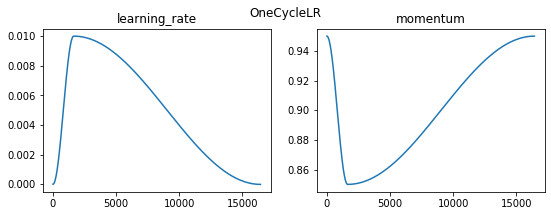

In [16]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = optim.DiffGrad
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'pct_start':0.1,
    'final_div_factor':10000.0,
    'steps_per_epoch': len(trn_loader)
}
CFG.scheduler = lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [17]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [18]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

In [19]:
from torch_optimizer import *

In [20]:
optim_list = [
    AdaBelief, AdaBound, AdaMod, AdamP, DiffGrad, Lamb, NovoGrad, QHAdam,
    RAdam, Ranger, RangerQH, RangerVA, SWATS, Yogi, torch.optim.Adam
]


optimizer: AdaBelief
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.770273,0.7702733062,0.713097,0.7130972127,0:5
2,0.766167,0.7661661745,0.705874,0.7058721067,0:3
3,0.755853,0.7558494210,0.695862,0.6958566653,0:3
4,0.742462,0.7424536004,0.684920,0.6849084555,0:3
5,0.729774,0.7297608791,0.675740,0.6757239059,0:3
6,0.715737,0.7157188045,0.662248,0.6622264395,0:3
7,0.701832,0.7018076612,0.649705,0.6496784363,0:3
8,0.687414,0.6873834604,0.635711,0.6356774232,0:3
9,0.670995,0.6709567264,0.618367,0.6183238217,0:3
10,0.653679,0.6536323903,0.602805,0.6027539926,0:4


epoch1 save best model... 0.7130972126893411
epoch2 save best model... 0.7058721066878977
epoch3 save best model... 0.6958566652886689
epoch4 save best model... 0.6849084554609243
epoch5 save best model... 0.6757239058511947
epoch6 save best model... 0.6622264394727546
epoch7 save best model... 0.6496784362814693
epoch8 save best model... 0.6356774232110565
epoch9 save best model... 0.6183238216576109
epoch10 save best model... 0.602753992640076
epoch11 save best model... 0.5832206365459329
epoch12 save best model... 0.5630041096639524
epoch13 save best model... 0.5395552526030833
epoch14 save best model... 0.5172185718605893
epoch15 save best model... 0.4962925737430946
epoch16 save best model... 0.472088782173626
epoch17 save best model... 0.4479980715993868
epoch18 save best model... 0.42748838688898194
epoch19 save best model... 0.41061677422230225
epoch20 save best model... 0.3952595660925455
epoch21 save best model... 0.3814578046695518
epoch22 save best model... 0.36872063716343

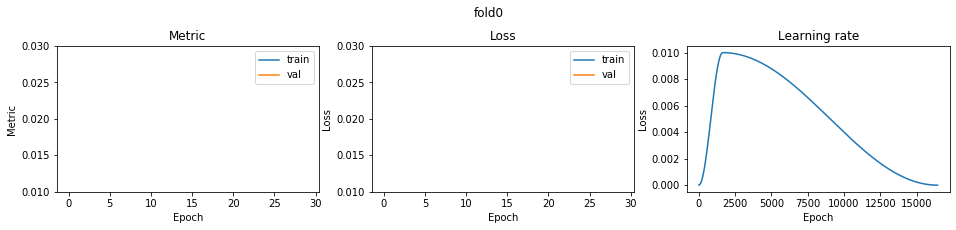

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.771266,0.7712677901,0.715818,0.7158196867,0:3
2,0.767052,0.7670517194,0.708930,0.7089294507,0:3
3,0.757195,0.7571917146,0.697243,0.6972375076,0:3
4,0.744061,0.7440536980,0.685592,0.6855819611,0:3
5,0.731284,0.7312711277,0.675025,0.6750097853,0:3
6,0.717862,0.7178444747,0.663768,0.6637475018,0:3
7,0.703924,0.7039004620,0.651521,0.6514952013,0:3
8,0.688855,0.6888250416,0.638378,0.6383445560,0:3
9,0.673198,0.6731609187,0.623086,0.6230454359,0:3
10,0.655931,0.6558857419,0.605706,0.6056561153,0:3


epoch1 save best model... 0.715819686712342
epoch2 save best model... 0.7089294507118368
epoch3 save best model... 0.6972375076190299
epoch4 save best model... 0.6855819610588967
epoch5 save best model... 0.6750097853307926
epoch6 save best model... 0.6637475017698404
epoch7 save best model... 0.6514952012878205
epoch8 save best model... 0.6383445560321038
epoch9 save best model... 0.6230454359328348
epoch10 save best model... 0.6056561153063771
epoch11 save best model... 0.5877341238587015
epoch12 save best model... 0.5665370476601688
epoch13 save best model... 0.5446054638993851
epoch14 save best model... 0.5244263450766403
epoch15 save best model... 0.5013799600135115
epoch16 save best model... 0.4780239753678057
epoch17 save best model... 0.4553320805435437
epoch18 save best model... 0.43667792991452187
epoch19 save best model... 0.41956820772350933
epoch20 save best model... 0.4032804566028314
epoch21 save best model... 0.3918611942893363
epoch22 save best model... 0.3804397386159

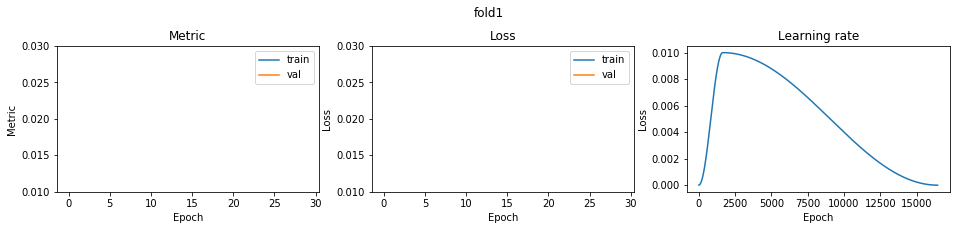

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.768467,0.7684667603,0.710184,0.7101822853,0:3
2,0.764605,0.7646035778,0.703288,0.7032848543,0:3
3,0.754402,0.7543981600,0.694592,0.6945855222,0:3
4,0.741084,0.7410753269,0.683359,0.6833478313,0:3
5,0.727729,0.7277160397,0.671009,0.6709928868,0:3
6,0.714981,0.7149632614,0.659799,0.6597768052,0:3
7,0.701506,0.7014828875,0.647742,0.6477150404,0:3
8,0.687763,0.6877336650,0.634592,0.6345575323,0:3
9,0.672887,0.6728511104,0.620941,0.6209001260,0:3
10,0.657127,0.6570824991,0.604302,0.6042518622,0:3


epoch1 save best model... 0.7101822852898253
epoch2 save best model... 0.7032848542794249
epoch3 save best model... 0.694585522206016
epoch4 save best model... 0.6833478312716177
epoch5 save best model... 0.6709928867566501
epoch6 save best model... 0.6597768051745436
epoch7 save best model... 0.6477150404390808
epoch8 save best model... 0.6345575322836509
epoch9 save best model... 0.6209001259750536
epoch10 save best model... 0.6042518622105473
epoch11 save best model... 0.5881087047197086
epoch12 save best model... 0.5669008234036651
epoch13 save best model... 0.5495070800691075
epoch14 save best model... 0.5250003172450088
epoch15 save best model... 0.5035771330061848
epoch16 save best model... 0.483439281396101
epoch17 save best model... 0.45980309169611316
epoch18 save best model... 0.4413394148392133
epoch19 save best model... 0.4237780226447583
epoch20 save best model... 0.4082231280417452
epoch21 save best model... 0.3970907368674097
epoch22 save best model... 0.384888419300473

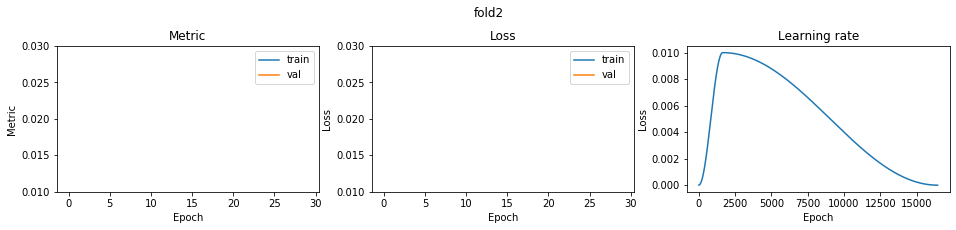

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.766451,0.7664499283,0.710512,0.7105117461,0:3
2,0.762610,0.7626080652,0.703981,0.7039772357,0:3
3,0.752074,0.7520689923,0.691706,0.6916985660,0:3
4,0.738731,0.7387203240,0.679529,0.6795154364,0:3
5,0.724908,0.7248929242,0.669981,0.6699633691,0:3
6,0.711117,0.7110959986,0.655821,0.6557977718,0:3
7,0.696770,0.6967435936,0.641104,0.6410726481,0:3
8,0.680787,0.6807530203,0.628481,0.6284426563,0:3
9,0.664012,0.6639701363,0.610671,0.6106235029,0:3
10,0.645414,0.6453627726,0.593101,0.5930443829,0:3


epoch1 save best model... 0.710511746113284
epoch2 save best model... 0.7039772357375855
epoch3 save best model... 0.6916985660316189
epoch4 save best model... 0.6795154363799475
epoch5 save best model... 0.669963369146838
epoch6 save best model... 0.65579777176668
epoch7 save best model... 0.6410726481255203
epoch8 save best model... 0.6284426563149976
epoch9 save best model... 0.6106235028670969
epoch10 save best model... 0.5930443828904276
epoch11 save best model... 0.5713676320936251
epoch12 save best model... 0.5495483051671526
epoch13 save best model... 0.5242502354000587
epoch14 save best model... 0.49945107972703384
epoch15 save best model... 0.475178151209425
epoch16 save best model... 0.45032069786262946
epoch17 save best model... 0.42739113939921786
epoch18 save best model... 0.40562321750069535
epoch19 save best model... 0.3874002511653379
epoch20 save best model... 0.37043131109250704
epoch21 save best model... 0.35769030658150586
epoch22 save best model... 0.3464978711072

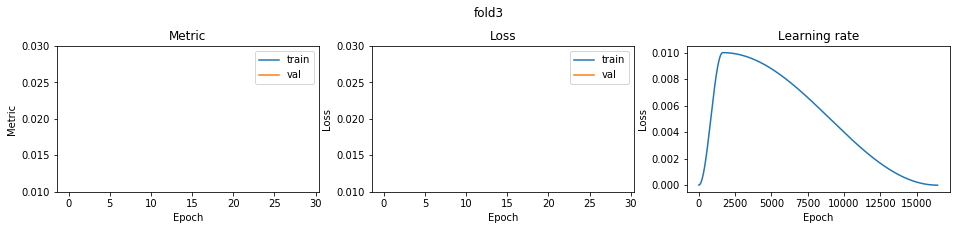

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.766758,0.7667570178,0.712813,0.7128129134,0:3
2,0.762951,0.7629488029,0.706456,0.7064531368,0:3
3,0.752997,0.7529918420,0.694501,0.6944937625,0:3
4,0.739227,0.7392165650,0.684385,0.6843742421,0:3
5,0.725059,0.7250434313,0.669216,0.6691977146,0:3
6,0.711143,0.7111221837,0.658905,0.6588817500,0:3
7,0.696163,0.6961362495,0.644386,0.6443559014,0:3
8,0.680545,0.6805118205,0.632738,0.6327019554,0:3
9,0.663531,0.6634898118,0.614773,0.6147273009,0:3
10,0.645404,0.6453531694,0.595354,0.5952983286,0:3


epoch1 save best model... 0.7128129133602481
epoch2 save best model... 0.7064531367569143
epoch3 save best model... 0.6944937624529446
epoch4 save best model... 0.684374242084173
epoch5 save best model... 0.6691977146003132
epoch6 save best model... 0.6588817500036235
epoch7 save best model... 0.6443559013629557
epoch8 save best model... 0.632701955433587
epoch9 save best model... 0.614727300907865
epoch10 save best model... 0.5952983285680176
epoch11 save best model... 0.5761306007522113
epoch12 save best model... 0.5538489856861175
epoch13 save best model... 0.5295950301958923
epoch14 save best model... 0.5047496947041948
epoch15 save best model... 0.4821613121684428
epoch16 save best model... 0.4569436794397228
epoch17 save best model... 0.4349249402591471
epoch18 save best model... 0.4134450946147458
epoch19 save best model... 0.39666880924500747
epoch20 save best model... 0.38051213486319524
epoch21 save best model... 0.3665865669896771
epoch22 save best model... 0.357461641535400

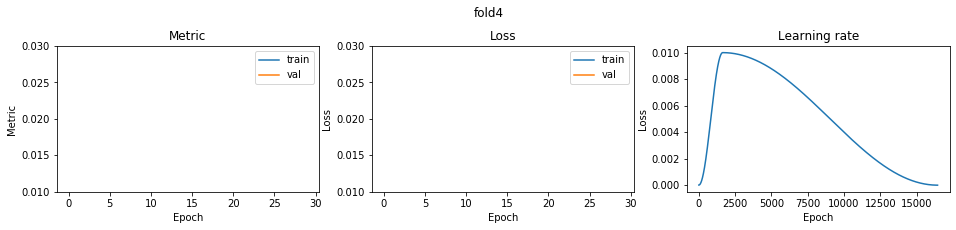

CV score: 0.33984046572666604

optimizer: AdaBound
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.755821,0.7558175035,0.676015,0.6759998287,0:4
2,0.631510,0.6314488319,0.399288,0.3991036540,0:3
3,0.183214,0.1827058652,0.053197,0.0523978692,0:3
4,0.045277,0.0443383701,0.030537,0.0294886050,0:3
5,0.032135,0.0310187999,0.025827,0.0246383119,0:3
6,0.028226,0.0270122652,0.024197,0.0229260848,0:3
7,0.026644,0.0253672472,0.023438,0.0221240482,0:4
8,0.025660,0.0243328648,0.022954,0.0215791161,0:3
9,0.025089,0.0237311070,0.022659,0.0212731450,0:3
10,0.024649,0.0232630902,0.022362,0.0209489862,0:3


epoch1 save best model... 0.6759998286503595
epoch2 save best model... 0.39910365398761083
epoch3 save best model... 0.0523978691845114
epoch4 save best model... 0.029488605009667695
epoch5 save best model... 0.024638311945937217
epoch6 save best model... 0.022926084818594275
epoch7 save best model... 0.022124048231640547
epoch8 save best model... 0.021579116089842313
epoch9 save best model... 0.02127314497438813
epoch10 save best model... 0.020948986173660446
epoch11 save best model... 0.0207829535406312
epoch12 save best model... 0.02061949489311504
epoch13 save best model... 0.02056188993410532
epoch14 save best model... 0.020479148235129602
epoch15 save best model... 0.020389037817750543
epoch16 save best model... 0.02027333452194454
epoch17 save best model... 0.02024834557162738
epoch18 save best model... 0.02014323681304422
epoch19 save best model... 0.02013990021902635
epoch20 save best model... 0.020116112429589238
epoch21 save best model... 0.020095884408759365
epoch22 save be

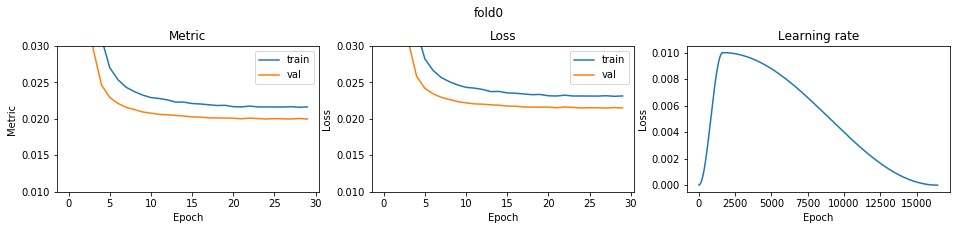

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.754704,0.7546987043,0.673702,0.6736856970,0:3
2,0.628012,0.6279484932,0.392145,0.3919573939,0:3
3,0.180227,0.1797130503,0.052126,0.0513213533,0:3
4,0.045139,0.0441988512,0.030295,0.0292297420,0:4
5,0.032057,0.0309380051,0.025758,0.0245560376,0:3
6,0.028306,0.0270900872,0.024292,0.0230252068,0:3
7,0.026713,0.0254325272,0.023506,0.0221834628,0:3
8,0.025792,0.0244667043,0.023066,0.0216997313,0:3
9,0.025143,0.0237845897,0.022775,0.0213952778,0:3
10,0.024779,0.0233924619,0.022586,0.0211735003,0:4


epoch1 save best model... 0.673685697046329
epoch2 save best model... 0.39195739387053513
epoch3 save best model... 0.05132135329226965
epoch4 save best model... 0.029229741953491595
epoch5 save best model... 0.02455603763016353
epoch6 save best model... 0.02302520676104551
epoch7 save best model... 0.022183462774551223
epoch8 save best model... 0.021699731278715547
epoch9 save best model... 0.021395277801462283
epoch10 save best model... 0.02117350029104064
epoch11 save best model... 0.020930994425956088
epoch12 save best model... 0.020847027030671397
epoch13 save best model... 0.020701878593577208
epoch14 save best model... 0.020614163074570275
epoch15 save best model... 0.020547690321974614
epoch16 save best model... 0.020490522382453705
epoch17 save best model... 0.020412576382932642
epoch18 save best model... 0.02032261835884385
epoch19 save best model... 0.020284555844349777
epoch20 save best model... 0.02025480180050211
epoch21 save best model... 0.020247754875776788
epoch22 sav

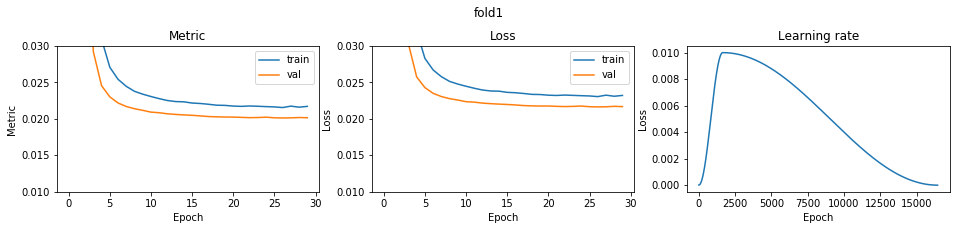

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.753088,0.7530824123,0.672827,0.6728111695,0:3
2,0.626365,0.6263005065,0.391064,0.3908748892,0:3
3,0.178992,0.1784759372,0.052104,0.0512983900,0:3
4,0.044948,0.0440058481,0.030282,0.0292273108,0:3
5,0.032074,0.0309569636,0.025836,0.0246474992,0:3
6,0.028319,0.0271047482,0.024188,0.0229203985,0:3
7,0.026731,0.0254531944,0.023486,0.0221742832,0:3
8,0.025722,0.0243956035,0.023002,0.0216457715,0:3
9,0.025201,0.0238409814,0.022769,0.0213700619,0:3
10,0.024667,0.0232824022,0.022498,0.0210898936,0:3


epoch1 save best model... 0.6728111694955858
epoch2 save best model... 0.39087488922070035
epoch3 save best model... 0.05129838998071505
epoch4 save best model... 0.029227310767421473
epoch5 save best model... 0.024647499169618753
epoch6 save best model... 0.022920398480848994
epoch7 save best model... 0.022174283204310356
epoch8 save best model... 0.021645771488496397
epoch9 save best model... 0.021370061873323583
epoch10 save best model... 0.021089893619969782
epoch11 save best model... 0.02088901646499768
epoch12 save best model... 0.02071669431117665
epoch13 save best model... 0.020653032493393713
epoch14 save best model... 0.020607734369790943
epoch15 save best model... 0.020407913476788907
epoch16 save best model... 0.020343891006089555
epoch17 save best model... 0.02028362503868147
epoch18 save best model... 0.020266289542448034
epoch19 save best model... 0.02025131410674045
epoch20 save best model... 0.02018144025407285
epoch21 save best model... 0.020173272671376172
epoch22 sa

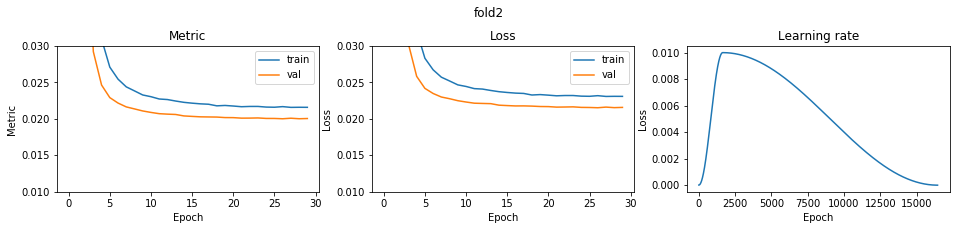

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.752767,0.7527618192,0.672195,0.6721792773,0:3
2,0.630289,0.6302269169,0.404305,0.4041268704,0:3
3,0.185186,0.1846810690,0.053466,0.0526695710,0:3
4,0.045658,0.0447208145,0.030662,0.0296163014,0:3
5,0.032037,0.0309211371,0.026209,0.0250407996,0:3
6,0.028267,0.0270525589,0.024494,0.0232336514,0:3
7,0.026663,0.0253882758,0.023660,0.0223567894,0:3
8,0.025694,0.0243685971,0.023163,0.0218088647,0:3
9,0.024971,0.0236123047,0.022816,0.0214274620,0:3
10,0.024646,0.0232595840,0.022600,0.0212002083,0:3


epoch1 save best model... 0.6721792772582017
epoch2 save best model... 0.4041268704285111
epoch3 save best model... 0.05266957099895271
epoch4 save best model... 0.029616301437173725
epoch5 save best model... 0.02504079955330878
epoch6 save best model... 0.023233651397813426
epoch7 save best model... 0.02235678939704607
epoch8 save best model... 0.021808864688818982
epoch9 save best model... 0.021427461969961068
epoch10 save best model... 0.02120020832179076
epoch11 save best model... 0.021029320803040253
epoch12 save best model... 0.020886835540753018
epoch13 save best model... 0.02078519421746288
epoch14 save best model... 0.020662833283101645
epoch15 save best model... 0.02057322579221736
epoch16 save best model... 0.02050963087783859
epoch17 save best model... 0.02050060312855556
epoch18 save best model... 0.02038257692331673
epoch19 save best model... 0.02035224889712684
epoch20 save best model... 0.020343511169755107
epoch21 save best model... 0.020265376511833934
epoch23 save be

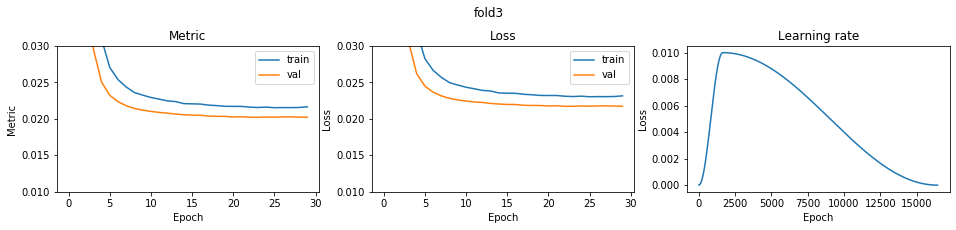

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.754740,0.7547358056,0.677611,0.6775966133,0:3
2,0.623178,0.6231114419,0.386337,0.3861444278,0:3
3,0.173145,0.1726186522,0.051620,0.0508130804,0:3
4,0.044662,0.0437149505,0.030101,0.0290382111,0:3
5,0.031846,0.0307254888,0.025750,0.0245695400,0:3
6,0.028152,0.0269319354,0.023996,0.0227386886,0:3
7,0.026679,0.0253977797,0.023274,0.0219699316,0:3
8,0.025685,0.0243581424,0.022735,0.0213810544,0:3
9,0.025133,0.0237736721,0.022430,0.0210573789,0:3
10,0.024668,0.0232810001,0.022191,0.0207861612,0:3


epoch1 save best model... 0.6775966132963437
epoch2 save best model... 0.38614442781598257
epoch3 save best model... 0.05081308044170736
epoch4 save best model... 0.02903821114577981
epoch5 save best model... 0.024569540031271264
epoch6 save best model... 0.022738688553689823
epoch7 save best model... 0.021969931590496
epoch8 save best model... 0.02138105437651718
epoch9 save best model... 0.021057378888503564
epoch10 save best model... 0.02078616122348162
epoch11 save best model... 0.020629232524467765
epoch12 save best model... 0.020416981758282503
epoch13 save best model... 0.020342691263060906
epoch14 save best model... 0.02021645346151533
epoch15 save best model... 0.020125840337849425
epoch16 save best model... 0.02006181919170811
epoch17 save best model... 0.02002621852964638
epoch18 save best model... 0.01995242249840077
epoch19 save best model... 0.019913461456469904
epoch20 save best model... 0.019850463648422162
epoch21 save best model... 0.019848709123247304
epoch22 save be

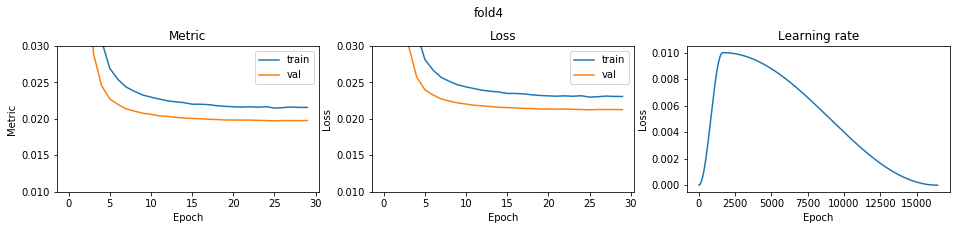

CV score: 0.02001566279321146

optimizer: AdaMod
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.729961,0.7299467002,0.375587,0.3753854026,0:4
2,0.053144,0.0519573627,0.021709,0.0201428725,0:4
3,0.022991,0.0213536976,0.020127,0.0184302229,0:4
4,0.022067,0.0203442102,0.019849,0.0181257031,0:3
5,0.021661,0.0199100380,0.019558,0.0178012858,0:4
6,0.021041,0.0192907858,0.019219,0.0175023395,0:4
7,0.020437,0.0186968734,0.018862,0.0171409434,0:4
8,0.019976,0.0182368664,0.018902,0.0171688902,0:3
9,0.019706,0.0179656665,0.018810,0.0170942706,0:4
10,0.019389,0.0176465538,0.018531,0.0168007027,0:4


epoch1 save best model... 0.3753854025605056
epoch2 save best model... 0.020142872520385137
epoch3 save best model... 0.0184302229128761
epoch4 save best model... 0.018125703148458978
epoch5 save best model... 0.017801285786278428
epoch6 save best model... 0.01750233948722923
epoch7 save best model... 0.017140943445859303
epoch9 save best model... 0.01709427061429192
epoch10 save best model... 0.01680070267977503
epoch11 save best model... 0.01670088553737535
epoch12 save best model... 0.016680843395378297
epoch14 save best model... 0.016610296070151423
epoch15 save best model... 0.016554714849638778
epoch16 save best model... 0.01630245073441764
epoch21 save best model... 0.016288443767637488
epoch22 save best model... 0.016254887997187623
fold0 score: 0.016254887866750337


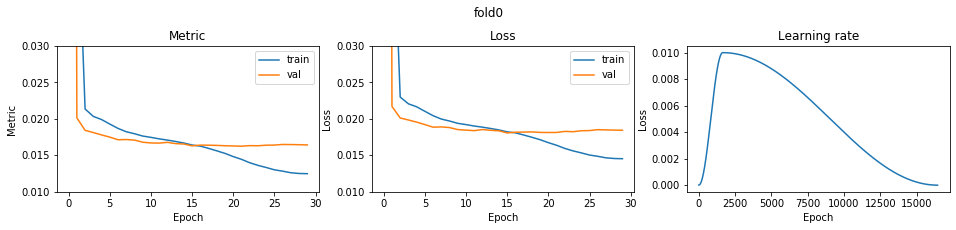

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.729161,0.7291467746,0.384019,0.3838231074,0:4
2,0.054126,0.0529444691,0.021855,0.0203210508,0:3
3,0.022838,0.0212111012,0.020402,0.0186933232,0:4
4,0.021913,0.0201873122,0.019738,0.0180256958,0:4
5,0.021478,0.0197241815,0.019729,0.0179821474,0:4
6,0.020824,0.0190668013,0.019528,0.0177773307,0:4
7,0.020264,0.0185155885,0.019154,0.0174396020,0:4
8,0.019868,0.0181278156,0.019214,0.0174849434,0:4
9,0.019579,0.0178350776,0.018919,0.0172224144,0:4
10,0.019253,0.0175035573,0.018786,0.0170680255,0:4


epoch1 save best model... 0.3838231073992484
epoch2 save best model... 0.02032105081796809
epoch3 save best model... 0.01869332324862005
epoch4 save best model... 0.01802569583922414
epoch5 save best model... 0.01798214735096165
epoch6 save best model... 0.017777330746908588
epoch7 save best model... 0.017439601971755325
epoch9 save best model... 0.017222414376741664
epoch10 save best model... 0.017068025544642262
epoch11 save best model... 0.017004215294963328
epoch12 save best model... 0.0169946944617341
epoch14 save best model... 0.016796441333897634
epoch16 save best model... 0.016768235537121878
epoch17 save best model... 0.016699137346083578
epoch18 save best model... 0.016602530581276125
epoch19 save best model... 0.016538358243607963
epoch22 save best model... 0.016519025687699532
fold1 score: 0.016519025668391824


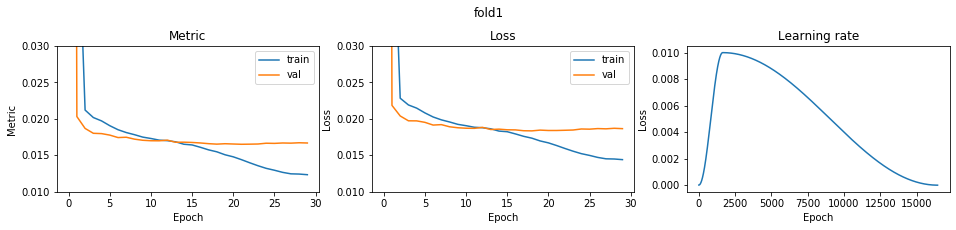

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.733156,0.7331438231,0.388031,0.3878386996,0:4
2,0.054939,0.0537532018,0.022069,0.0205074798,0:4
3,0.022810,0.0211706265,0.020484,0.0187895164,0:4
4,0.022069,0.0203533888,0.020178,0.0184121710,0:4
5,0.021592,0.0198419934,0.019568,0.0178232165,0:4
6,0.020880,0.0191249515,0.019396,0.0176534967,0:4
7,0.020469,0.0187242682,0.019282,0.0175507249,0:4
8,0.020066,0.0183299349,0.018903,0.0171852416,0:3
9,0.019589,0.0178474137,0.018777,0.0170222696,0:3
10,0.019420,0.0176768727,0.018886,0.0171550720,0:4


epoch1 save best model... 0.3878386995601719
epoch2 save best model... 0.020507479838960722
epoch3 save best model... 0.018789516406260663
epoch4 save best model... 0.018412171029306458
epoch5 save best model... 0.017823216541421782
epoch6 save best model... 0.017653496717190888
epoch7 save best model... 0.017550724861121893
epoch8 save best model... 0.01718524155943506
epoch9 save best model... 0.017022269562151606
epoch11 save best model... 0.016976481446591887
epoch12 save best model... 0.01682382602860829
epoch14 save best model... 0.016619613570687194
epoch16 save best model... 0.016602965515920897
epoch17 save best model... 0.01652007971504713
epoch18 save best model... 0.016512845051478053
epoch19 save best model... 0.016481997261252903
epoch20 save best model... 0.01637168865740863
epoch21 save best model... 0.01632514640885813
epoch23 save best model... 0.016323396568749957
fold2 score: 0.016323396510194


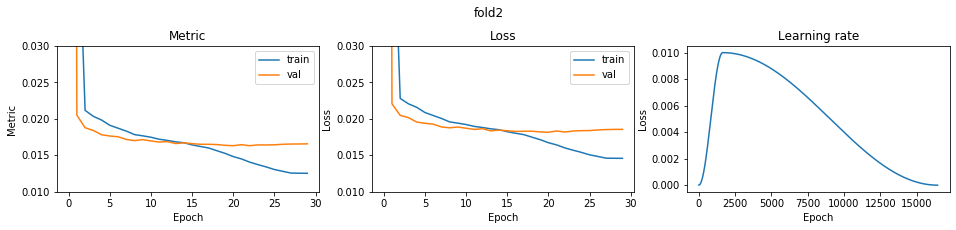

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.730666,0.7306529573,0.423342,0.4231772752,0:4
2,0.058573,0.0574021254,0.021955,0.0204089003,0:3
3,0.023016,0.0213777761,0.020520,0.0188093942,0:4
4,0.021935,0.0202066689,0.020055,0.0183183408,0:4
5,0.021519,0.0197675518,0.019763,0.0180253408,0:3
6,0.020868,0.0191108700,0.019435,0.0177069199,0:4
7,0.020347,0.0185985014,0.019242,0.0175054829,0:4
8,0.019938,0.0181963426,0.019182,0.0174381157,0:4
9,0.019676,0.0179348688,0.018986,0.0172680113,0:3
10,0.019358,0.0176167909,0.018912,0.0171680685,0:4


epoch1 save best model... 0.4231772752041697
epoch2 save best model... 0.020408900259041435
epoch3 save best model... 0.01880939422782027
epoch4 save best model... 0.01831834079371023
epoch5 save best model... 0.01802534075424177
epoch6 save best model... 0.017706919908268982
epoch7 save best model... 0.017505482949554105
epoch8 save best model... 0.0174381156547466
epoch9 save best model... 0.017268011273056744
epoch10 save best model... 0.0171680685128499
epoch11 save best model... 0.017004208572225853
epoch12 save best model... 0.016910454871850025
epoch14 save best model... 0.016904995006621563
epoch16 save best model... 0.016662744770849076
epoch18 save best model... 0.016508905035029917
epoch20 save best model... 0.016497569923673103
epoch22 save best model... 0.016471996437970354
fold3 score: 0.01647199636569039


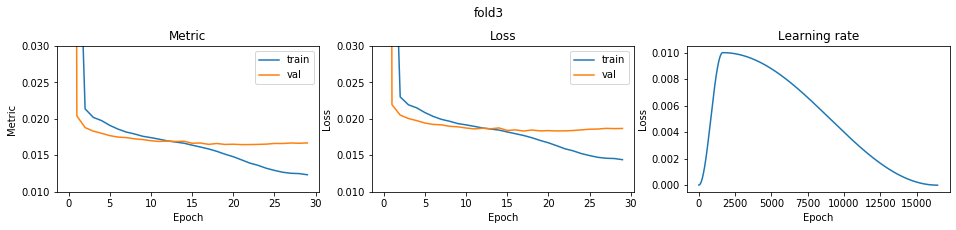

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.727754,0.7277387617,0.366931,0.3667214593,0:4
2,0.051946,0.0507495270,0.021685,0.0200987580,0:4
3,0.022971,0.0213319616,0.020460,0.0187447165,0:4
4,0.022125,0.0203987624,0.019791,0.0180285343,0:4
5,0.021551,0.0197964309,0.019548,0.0178121720,0:4
6,0.020913,0.0191564714,0.019321,0.0175990842,0:4
7,0.020398,0.0186535174,0.019042,0.0173145119,0:4
8,0.020009,0.0182669332,0.019076,0.0173532138,0:4
9,0.019622,0.0178796479,0.018786,0.0170708236,0:4
10,0.019374,0.0176280745,0.018774,0.0170395603,0:4


epoch1 save best model... 0.36672145933388034
epoch2 save best model... 0.020098757989076656
epoch3 save best model... 0.018744716514114097
epoch4 save best model... 0.018028534278019006
epoch5 save best model... 0.01781217198063681
epoch6 save best model... 0.01759908419136374
epoch7 save best model... 0.01731451185280139
epoch9 save best model... 0.01707082359175408
epoch10 save best model... 0.017039560335253393
epoch11 save best model... 0.016888078161279813
epoch12 save best model... 0.01688357079422827
epoch14 save best model... 0.016764172153432847
epoch16 save best model... 0.0166674958677763
epoch17 save best model... 0.016644909602413823
epoch19 save best model... 0.016560723133605813
epoch21 save best model... 0.01649537699504974
epoch22 save best model... 0.0164807471414871
fold4 score: 0.01648074702998243


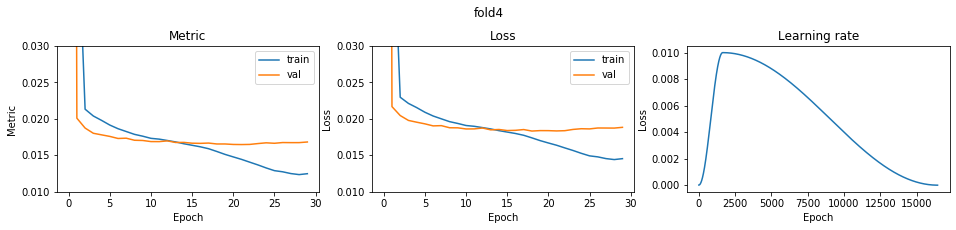

CV score: 0.016410009667571113

optimizer: AdamP
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.440366,0.4399491902,0.023311,0.0219383183,0:5
2,0.023990,0.0223933109,0.021231,0.0195518624,0:4
3,0.022691,0.0209613438,0.019935,0.0182239250,0:4
4,0.021500,0.0197779200,0.019390,0.0176933459,0:4
5,0.020599,0.0189014168,0.019236,0.0175735919,0:4
6,0.020134,0.0184400059,0.019070,0.0173895194,0:5
7,0.019846,0.0181434342,0.018738,0.0170475490,0:5
8,0.019673,0.0179636805,0.018708,0.0170360345,0:5
9,0.019487,0.0177636064,0.018726,0.0170309493,0:4
10,0.019423,0.0176895266,0.018639,0.0169327818,0:4


epoch1 save best model... 0.02193831831878709
epoch2 save best model... 0.01955186244702828
epoch3 save best model... 0.018223925047725915
epoch4 save best model... 0.0176933459029586
epoch5 save best model... 0.017573591913170858
epoch6 save best model... 0.017389519350149228
epoch7 save best model... 0.017047548978875872
epoch8 save best model... 0.01703603452746173
epoch9 save best model... 0.017030949277086246
epoch10 save best model... 0.016932781769603424
epoch12 save best model... 0.016738301396777254
epoch13 save best model... 0.016735603937832532
epoch14 save best model... 0.016618746513148645
epoch15 save best model... 0.016559468736290796
epoch17 save best model... 0.016466423105406056
epoch18 save best model... 0.016422469459541972
epoch19 save best model... 0.01629754295424136
epoch20 save best model... 0.016241892767064527
epoch21 save best model... 0.01618892621282904
epoch23 save best model... 0.016176501866896766
fold0 score: 0.01617650163677997


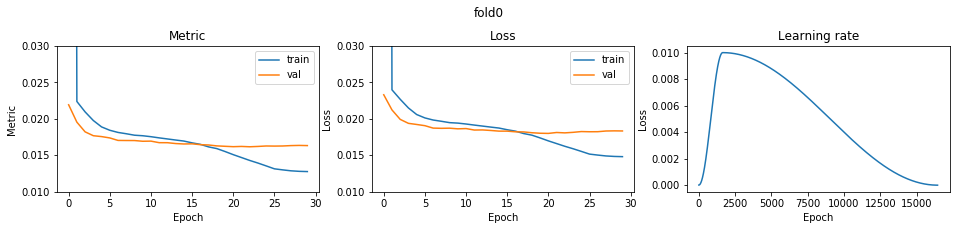

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.439760,0.4393426380,0.023334,0.0219733094,0:4
2,0.023973,0.0223770943,0.021148,0.0194598795,0:4
3,0.022848,0.0211132890,0.020814,0.0190993801,0:4
4,0.021570,0.0198361014,0.019736,0.0180115997,0:4
5,0.020675,0.0189677357,0.019328,0.0176594010,0:4
6,0.020140,0.0184437199,0.019195,0.0175104900,0:4
7,0.019920,0.0182200731,0.019043,0.0173479067,0:4
8,0.019611,0.0178977744,0.018940,0.0172315551,0:4
9,0.019505,0.0177836330,0.018953,0.0172380400,0:4
10,0.019449,0.0177192272,0.018878,0.0171828734,0:5


epoch1 save best model... 0.02197330939719497
epoch2 save best model... 0.019459879521079367
epoch3 save best model... 0.019099380128810472
epoch4 save best model... 0.018011599736690087
epoch5 save best model... 0.017659401004604773
epoch6 save best model... 0.017510490034070094
epoch7 save best model... 0.017347906682004578
epoch8 save best model... 0.01723155511917042
epoch10 save best model... 0.017182873420656664
epoch11 save best model... 0.017126047845626848
epoch12 save best model... 0.017030109910900867
epoch13 save best model... 0.016913720348026153
epoch15 save best model... 0.016859103025608384
epoch16 save best model... 0.01670965238791116
epoch19 save best model... 0.016599803367036776
epoch20 save best model... 0.01656926154227124
epoch21 save best model... 0.016533986744244906
epoch22 save best model... 0.016499762047751873
fold1 score: 0.016499762023081437


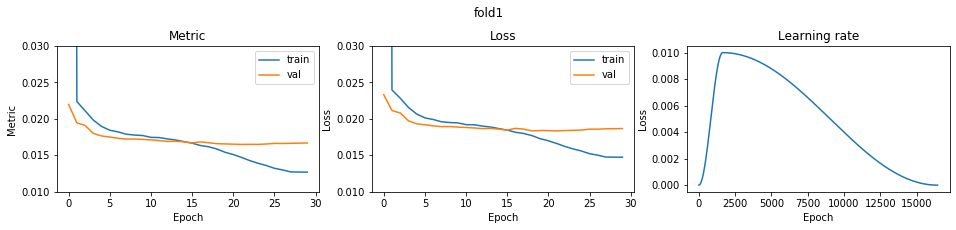

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.439761,0.4393458795,0.024268,0.0229156564,0:5
2,0.023995,0.0223981912,0.021016,0.0193352494,0:5
3,0.022625,0.0208913071,0.020856,0.0191150951,0:5
4,0.021598,0.0198687943,0.019743,0.0180337288,0:5
5,0.020733,0.0190316888,0.019510,0.0178084770,0:5
6,0.020137,0.0184415922,0.019133,0.0174541831,0:5
7,0.019881,0.0181811196,0.018949,0.0172571972,0:5
8,0.019684,0.0179781876,0.018796,0.0171015647,0:5
9,0.019490,0.0177694827,0.018970,0.0172494956,0:5
10,0.019488,0.0177584436,0.018715,0.0169973085,0:5


epoch1 save best model... 0.02291565642820102
epoch2 save best model... 0.019335249394745374
epoch3 save best model... 0.019115095133737228
epoch4 save best model... 0.01803372884718805
epoch5 save best model... 0.01780847702294208
epoch6 save best model... 0.017454183067787777
epoch7 save best model... 0.017257197172266186
epoch8 save best model... 0.01710156469987177
epoch10 save best model... 0.016997308472218534
epoch13 save best model... 0.01677452333994663
epoch14 save best model... 0.016670098989152858
epoch16 save best model... 0.01665986024159883
epoch17 save best model... 0.016495063371521772
epoch18 save best model... 0.016459641165014523
epoch19 save best model... 0.016408468480142355
epoch22 save best model... 0.01638204341626576
epoch23 save best model... 0.01629191030671586
fold2 score: 0.016291910185936172


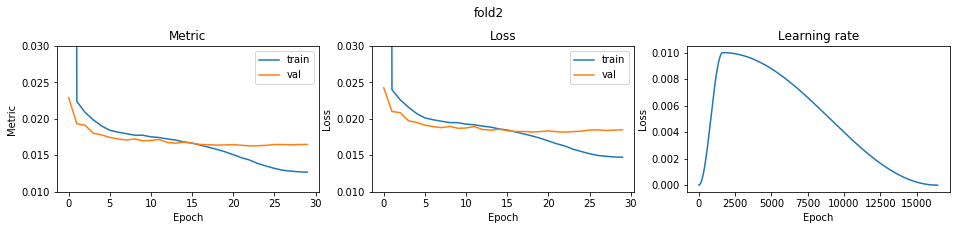

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.441603,0.4411894516,0.023606,0.0222473524,0:5
2,0.024151,0.0225733616,0.021139,0.0194466126,0:5
3,0.022925,0.0211951400,0.020320,0.0186029179,0:5
4,0.021680,0.0199496519,0.019900,0.0181939837,0:5
5,0.020571,0.0188695476,0.019412,0.0177176330,0:5
6,0.020184,0.0184859493,0.019341,0.0176605281,0:5
7,0.019929,0.0182352334,0.019321,0.0176181118,0:5
8,0.019683,0.0179733738,0.019060,0.0173540687,0:5
9,0.019556,0.0178383493,0.019027,0.0172904908,0:5
10,0.019391,0.0176623635,0.018937,0.0172169109,0:5


epoch1 save best model... 0.022247352445145946
epoch2 save best model... 0.019446612633170733
epoch3 save best model... 0.018602917910657466
epoch4 save best model... 0.018193983673149876
epoch5 save best model... 0.01771763301749368
epoch6 save best model... 0.017660528136701544
epoch7 save best model... 0.017618111804857478
epoch8 save best model... 0.017354068658601042
epoch9 save best model... 0.017290490814367974
epoch10 save best model... 0.01721691092633237
epoch11 save best model... 0.017181904269870294
epoch12 save best model... 0.017145598812160295
epoch13 save best model... 0.01705284082078309
epoch14 save best model... 0.016940393380328572
epoch15 save best model... 0.016830842288164317
epoch18 save best model... 0.016605287305756146
epoch19 save best model... 0.01660405468950918
epoch20 save best model... 0.016601376000002603
epoch21 save best model... 0.016595282515930967
epoch22 save best model... 0.01652415522792141
epoch23 save best model... 0.01652295506837224
fold3 s

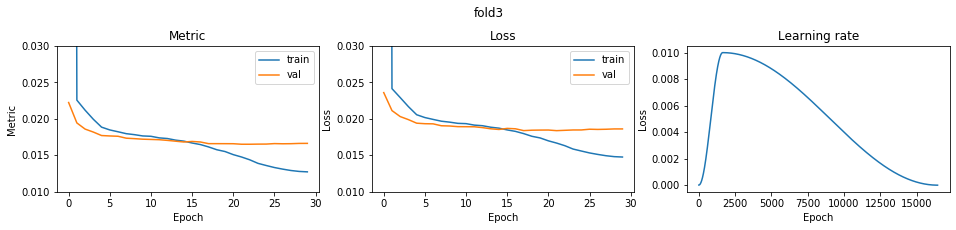

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.441489,0.4410748324,0.023351,0.0219780649,0:5
2,0.024003,0.0224127426,0.020967,0.0192330506,0:5
3,0.022781,0.0210565533,0.020131,0.0183961876,0:5
4,0.021479,0.0197614161,0.019685,0.0179738526,0:5
5,0.020538,0.0188399313,0.019350,0.0176575677,0:5
6,0.020110,0.0184142093,0.019259,0.0175792271,0:5
7,0.019842,0.0181395386,0.018919,0.0172209657,0:5
8,0.019662,0.0179514261,0.018975,0.0172956878,0:5
9,0.019521,0.0177984526,0.018990,0.0172798536,0:5
10,0.019423,0.0176929863,0.018709,0.0170567378,0:5


epoch1 save best model... 0.021978064927703156
epoch2 save best model... 0.019233050591955153
epoch3 save best model... 0.018396187600401785
epoch4 save best model... 0.017973852633649232
epoch5 save best model... 0.017657567709599514
epoch6 save best model... 0.01757922705924796
epoch7 save best model... 0.01722096568419002
epoch10 save best model... 0.017056737834659823
epoch11 save best model... 0.017026612824062416
epoch13 save best model... 0.016824546357476766
epoch14 save best model... 0.016780778192034614
epoch16 save best model... 0.016715538689701187
epoch17 save best model... 0.016563808101660027
epoch18 save best model... 0.016497350541412287
epoch20 save best model... 0.016434898070889208
epoch21 save best model... 0.016427517405250756
epoch24 save best model... 0.016423085749845162
fold4 score: 0.016423085654278725


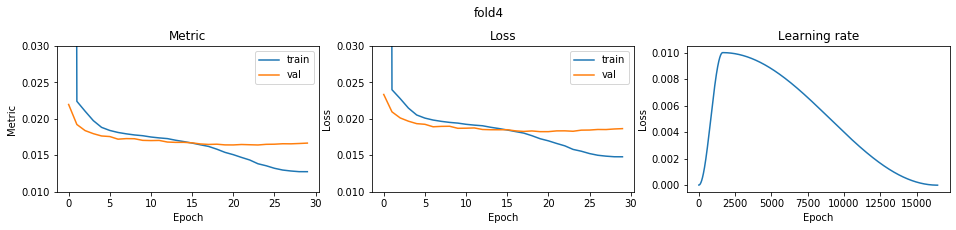

CV score: 0.01638284171629129

optimizer: DiffGrad
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.546462,0.5462639660,0.032767,0.0317386290,0:5
2,0.026084,0.0246572789,0.021320,0.0197279312,0:5
3,0.022896,0.0212152080,0.020397,0.0186401714,0:5
4,0.021828,0.0201078680,0.019846,0.0180867225,0:5
5,0.021007,0.0192756904,0.019362,0.0176137466,0:5
6,0.020499,0.0187714586,0.019093,0.0173439783,0:5
7,0.020121,0.0183939536,0.018905,0.0171934784,0:5
8,0.019704,0.0179811122,0.018765,0.0170412727,0:5
9,0.019529,0.0177949580,0.018693,0.0169731355,0:5
10,0.019305,0.0175715583,0.018593,0.0168385964,0:5


epoch1 save best model... 0.0317386289918477
epoch2 save best model... 0.019727931225965126
epoch3 save best model... 0.018640171357161093
epoch4 save best model... 0.01808672254069248
epoch5 save best model... 0.017613746570359603
epoch6 save best model... 0.01734397831905404
epoch7 save best model... 0.01719347842733518
epoch8 save best model... 0.01704127274046319
epoch9 save best model... 0.016973135492219196
epoch10 save best model... 0.016838596402274992
epoch12 save best model... 0.016806030214036517
epoch13 save best model... 0.01663015191029579
epoch14 save best model... 0.016510519667916796
epoch16 save best model... 0.016470888580337743
epoch17 save best model... 0.016448460318199052
epoch18 save best model... 0.01638354891253495
epoch20 save best model... 0.016316722207416298
epoch22 save best model... 0.016297372106403318
epoch23 save best model... 0.01627047749953281
fold0 score: 0.01627047740557223


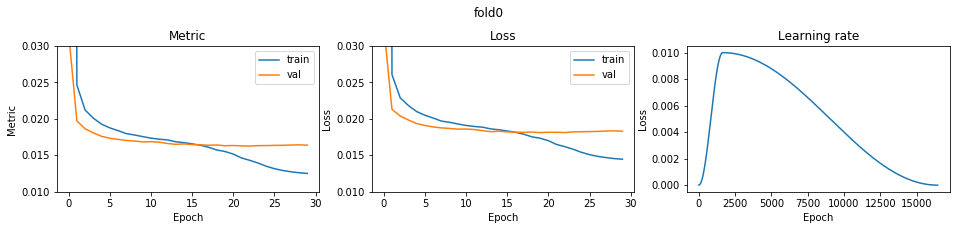

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.544009,0.5438110065,0.032923,0.0319029661,0:5
2,0.026190,0.0247622967,0.021785,0.0201658932,0:5
3,0.022721,0.0210414530,0.020668,0.0189502898,0:5
4,0.021764,0.0200274852,0.019791,0.0180765784,0:5
5,0.020874,0.0191376954,0.019431,0.0177365524,0:5
6,0.020481,0.0187445827,0.019130,0.0174210438,0:5
7,0.019966,0.0182322787,0.019104,0.0173941073,0:5
8,0.019718,0.0179839452,0.019100,0.0173616130,0:5
9,0.019476,0.0177450656,0.018786,0.0170785497,0:5
10,0.019240,0.0174998267,0.018847,0.0171540069,0:5


epoch1 save best model... 0.031902966055383335
epoch2 save best model... 0.02016589317048946
epoch3 save best model... 0.018950289772688922
epoch4 save best model... 0.01807657842676918
epoch5 save best model... 0.01773655241430417
epoch6 save best model... 0.017421043762081194
epoch7 save best model... 0.01739410732190154
epoch8 save best model... 0.017361613023600918
epoch9 save best model... 0.01707854970532524
epoch12 save best model... 0.01706994651193145
epoch13 save best model... 0.016987800151262476
epoch14 save best model... 0.016972034764733936
epoch15 save best model... 0.016819993376487423
epoch17 save best model... 0.016737139185622765
epoch19 save best model... 0.01664512422157328
epoch20 save best model... 0.01653523543519837
fold1 score: 0.01653523537902433


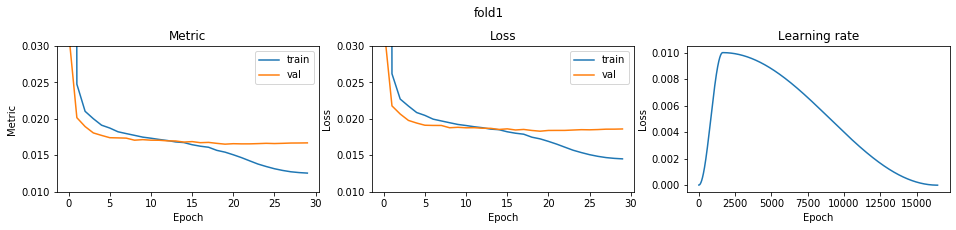

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.542982,0.5427792807,0.032709,0.0316754750,0:5
2,0.025984,0.0245468727,0.021206,0.0195931395,0:5
3,0.022773,0.0210870524,0.020352,0.0186764137,0:5
4,0.021715,0.0199841083,0.019725,0.0180202352,0:5
5,0.020925,0.0191903935,0.019376,0.0176711581,0:5
6,0.020448,0.0187099880,0.019326,0.0176220482,0:5
7,0.020080,0.0183476323,0.018978,0.0172769844,0:5
8,0.019744,0.0180101612,0.018810,0.0171089305,0:5
9,0.019488,0.0177543773,0.018722,0.0170175279,0:5
10,0.019278,0.0175481579,0.018699,0.0169469213,0:5


epoch1 save best model... 0.03167547503141247
epoch2 save best model... 0.019593139482913746
epoch3 save best model... 0.018676413737931753
epoch4 save best model... 0.01802023515333569
epoch5 save best model... 0.01767115805558665
epoch6 save best model... 0.017622048219873412
epoch7 save best model... 0.017276984350881007
epoch8 save best model... 0.017108930507621765
epoch9 save best model... 0.017017527909278463
epoch10 save best model... 0.016946921307754003
epoch12 save best model... 0.016865237430756578
epoch13 save best model... 0.016840590878312748
epoch14 save best model... 0.016786412563829373
epoch15 save best model... 0.016686625750453182
epoch16 save best model... 0.016599332604376484
epoch17 save best model... 0.016597554187370366
epoch18 save best model... 0.016442680554869752
epoch19 save best model... 0.016385031908395745
epoch21 save best model... 0.01636871235034757
epoch22 save best model... 0.01635105758213656
fold2 score: 0.016351057592902805


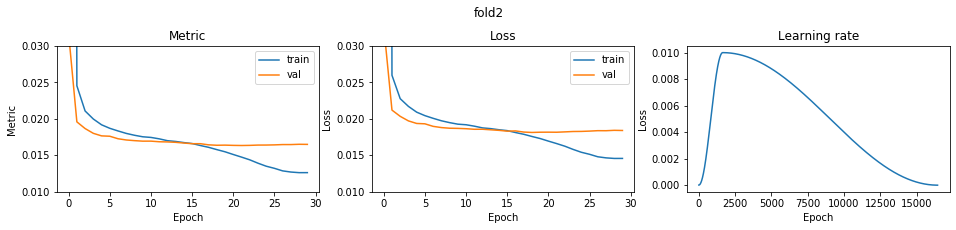

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.544738,0.5445362725,0.034163,0.0331312737,0:5
2,0.026069,0.0246350970,0.021575,0.0199628985,0:5
3,0.022755,0.0210779962,0.020622,0.0188643971,0:5
4,0.021948,0.0202112354,0.019964,0.0182584073,0:5
5,0.021220,0.0194719825,0.019874,0.0181047968,0:5
6,0.020545,0.0188049030,0.019437,0.0176881955,0:5
7,0.020131,0.0183997229,0.019256,0.0175358350,0:5
8,0.019754,0.0180239266,0.019224,0.0175028448,0:5
9,0.019511,0.0177808868,0.018911,0.0171853067,0:5
10,0.019331,0.0175981052,0.018897,0.0171590457,0:5


epoch1 save best model... 0.03313127373152143
epoch2 save best model... 0.01996289849501943
epoch3 save best model... 0.018864397094044028
epoch4 save best model... 0.018258407272415445
epoch5 save best model... 0.018104796750992875
epoch6 save best model... 0.01768819553340554
epoch7 save best model... 0.01753583498053032
epoch8 save best model... 0.017502844827525437
epoch9 save best model... 0.017185306715819314
epoch10 save best model... 0.01715904568748417
epoch11 save best model... 0.01707607902425229
epoch12 save best model... 0.01693495196674299
epoch14 save best model... 0.016825746614188973
epoch15 save best model... 0.01679168022099823
epoch16 save best model... 0.016761372981334195
epoch17 save best model... 0.01662911430578297
epoch18 save best model... 0.016562479080585658
epoch19 save best model... 0.016516151389527157
epoch21 save best model... 0.01644998084168228
epoch22 save best model... 0.016441607988674983
epoch24 save best model... 0.01644084050037934
fold3 score:

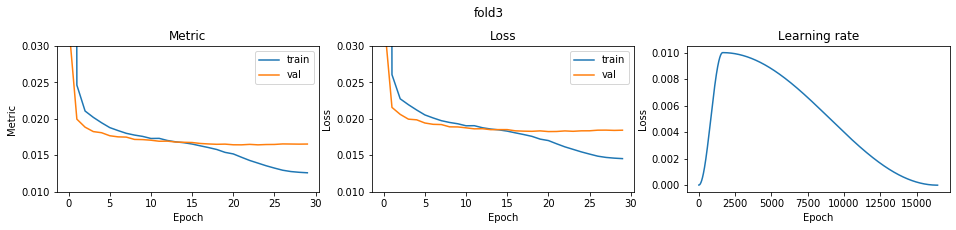

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.544100,0.5438978785,0.032055,0.0310327053,0:5
2,0.026177,0.0247405735,0.021260,0.0196360467,0:5
3,0.022795,0.0211127187,0.020120,0.0184407723,0:5
4,0.021743,0.0200285447,0.019825,0.0180925148,0:5
5,0.021013,0.0192831398,0.019347,0.0176528302,0:5
6,0.020421,0.0186925444,0.019000,0.0172983295,0:5
7,0.020050,0.0183197095,0.018951,0.0172417627,0:5
8,0.019696,0.0179659133,0.018951,0.0172418858,0:5
9,0.019448,0.0177137835,0.018769,0.0170500204,0:5
10,0.019222,0.0174825908,0.018619,0.0169014773,0:5


epoch1 save best model... 0.03103270532822147
epoch2 save best model... 0.019636046740487387
epoch3 save best model... 0.01844077231129101
epoch4 save best model... 0.018092514813404556
epoch5 save best model... 0.017652830171371238
epoch6 save best model... 0.017298329538392044
epoch7 save best model... 0.01724176267989336
epoch9 save best model... 0.017050020422167005
epoch10 save best model... 0.016901477344826304
epoch12 save best model... 0.016869883755633527
epoch13 save best model... 0.016853632984984164
epoch14 save best model... 0.01670187454594295
epoch16 save best model... 0.016642909838153995
epoch17 save best model... 0.016570972323264918
epoch18 save best model... 0.016559448311686653
epoch20 save best model... 0.01652288897332135
epoch21 save best model... 0.016450588829000745
fold4 score: 0.016450588660124773


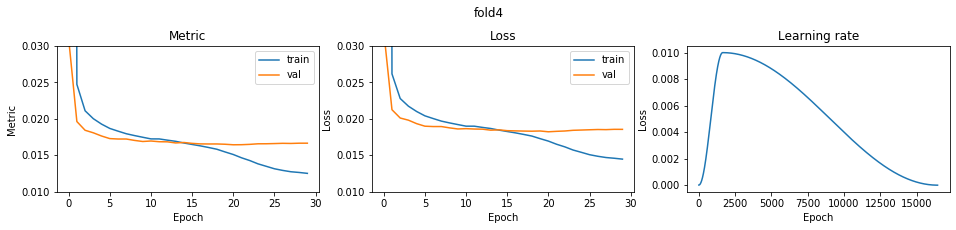

CV score: 0.0164096368405466

optimizer: Lamb
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.742575,0.7425737063,0.683809,0.6838028684,0:6
2,0.640383,0.6403518792,0.493022,0.4929087821,0:6
3,0.180010,0.1794951557,0.032615,0.0316347507,0:6
4,0.022590,0.0211839778,0.019847,0.0182895573,0:5
5,0.020301,0.0187292014,0.019327,0.0177589722,0:5
6,0.019730,0.0181287639,0.018944,0.0173578349,0:5
7,0.019297,0.0176749004,0.018686,0.0170777238,0:5
8,0.018840,0.0171909336,0.018516,0.0168581809,0:5
9,0.018467,0.0167941890,0.018411,0.0167497821,0:5
10,0.018144,0.0164479914,0.018279,0.0166192832,0:6


epoch1 save best model... 0.6838028684020857
epoch2 save best model... 0.4929087821334804
epoch3 save best model... 0.03163475073823081
epoch4 save best model... 0.01828955725463349
epoch5 save best model... 0.017758972186739462
epoch6 save best model... 0.017357834940245863
epoch7 save best model... 0.017077723781075457
epoch8 save best model... 0.016858180851626776
epoch9 save best model... 0.01674978211352385
epoch10 save best model... 0.016619283184069706
epoch11 save best model... 0.016559005965709958
epoch12 save best model... 0.016417511180891808
epoch14 save best model... 0.016399169602942628
epoch15 save best model... 0.016380887061934538
epoch17 save best model... 0.016349124086167927
fold0 score: 0.016349123981740425


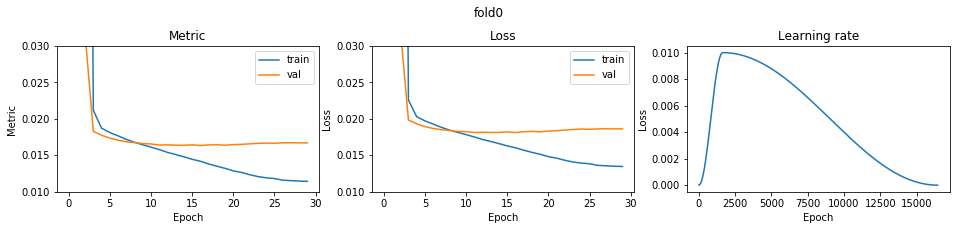

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.742094,0.7420915499,0.684141,0.6841353495,0:6
2,0.637184,0.6371514127,0.482672,0.4825519256,0:5
3,0.174768,0.1742444279,0.032257,0.0312666658,0:6
4,0.022523,0.0211104579,0.019904,0.0183685444,0:5
5,0.020209,0.0186378105,0.019439,0.0178647967,0:6
6,0.019588,0.0179800108,0.019158,0.0175625407,0:5
7,0.019171,0.0175397624,0.018914,0.0173133577,0:6
8,0.018807,0.0171554811,0.018775,0.0171463999,0:6
9,0.018396,0.0167187728,0.018632,0.0169781646,0:6
10,0.018102,0.0164039304,0.018456,0.0167891497,0:5


epoch1 save best model... 0.6841353495263869
epoch2 save best model... 0.482551925626152
epoch3 save best model... 0.03126666579954878
epoch4 save best model... 0.018368544363845152
epoch5 save best model... 0.017864796736821495
epoch6 save best model... 0.017562540736932992
epoch7 save best model... 0.01731335767900232
epoch8 save best model... 0.017146399924537946
epoch9 save best model... 0.016978164557617952
epoch10 save best model... 0.01678914966146165
epoch12 save best model... 0.016683372150105884
epoch13 save best model... 0.016666221787813965
epoch14 save best model... 0.016586209613618504
fold1 score: 0.016586209527276012


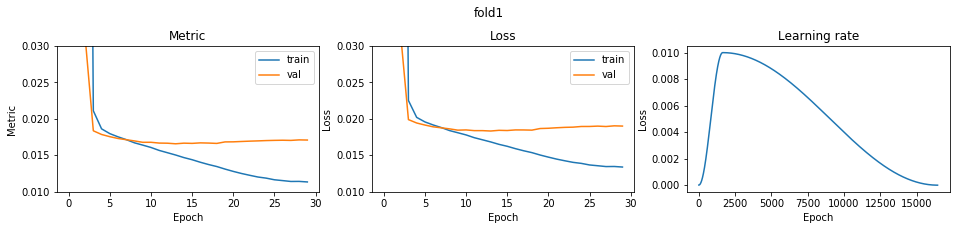

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.744740,0.7447394062,0.684164,0.6841589343,0:6
2,0.645686,0.6456577126,0.507300,0.5071961191,0:6
3,0.189595,0.1890965753,0.033517,0.0325494123,0:6
4,0.022645,0.0212369225,0.019858,0.0183116393,0:5
5,0.020183,0.0186063115,0.019254,0.0176906166,0:6
6,0.019580,0.0179754619,0.018884,0.0172954375,0:5
7,0.019199,0.0175712667,0.018724,0.0171086796,0:5
8,0.018804,0.0171525394,0.018576,0.0169442091,0:5
9,0.018453,0.0167774695,0.018446,0.0167885089,0:5
10,0.018036,0.0163365227,0.018351,0.0166752712,0:6


epoch1 save best model... 0.684158934333325
epoch2 save best model... 0.5071961191472445
epoch3 save best model... 0.032549412264116236
epoch4 save best model... 0.018311639332719017
epoch5 save best model... 0.017690616590220216
epoch6 save best model... 0.017295437514201387
epoch7 save best model... 0.017108679588440204
epoch8 save best model... 0.01694420907912934
epoch9 save best model... 0.016788508941449766
epoch10 save best model... 0.016675271238349963
epoch11 save best model... 0.016516196025218446
epoch12 save best model... 0.01645401696527899
epoch13 save best model... 0.01640533074680576
fold2 score: 0.01640533079624911


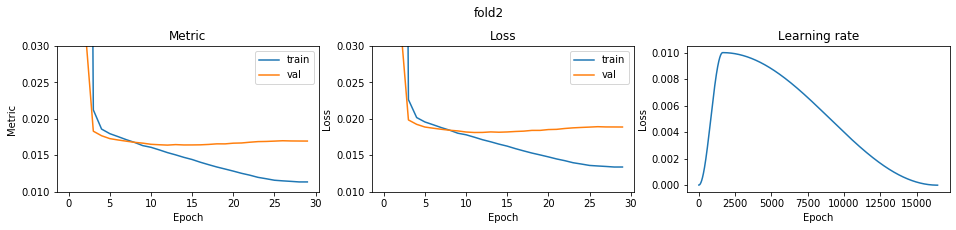

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.744239,0.7442374493,0.685294,0.6852887682,0:6
2,0.642636,0.6426065080,0.498913,0.4988030978,0:6
3,0.183725,0.1832167866,0.033113,0.0321356983,0:6
4,0.022581,0.0211696192,0.019998,0.0184446755,0:5
5,0.020179,0.0186033912,0.019469,0.0179069581,0:5
6,0.019574,0.0179682643,0.019165,0.0175567985,0:5
7,0.019086,0.0174543937,0.018918,0.0173046742,0:6
8,0.018707,0.0170501047,0.018660,0.0170168204,0:6
9,0.018350,0.0166707352,0.018642,0.0169754248,0:5
10,0.018061,0.0163618356,0.018451,0.0167669820,0:6


epoch1 save best model... 0.6852887681785097
epoch2 save best model... 0.49880309779714616
epoch3 save best model... 0.032135698291767975
epoch4 save best model... 0.018444675522811864
epoch5 save best model... 0.017906958127822854
epoch6 save best model... 0.017556798549746597
epoch7 save best model... 0.017304674185948245
epoch8 save best model... 0.01701682041991069
epoch9 save best model... 0.016975424795120885
epoch10 save best model... 0.0167669820041313
epoch11 save best model... 0.01667624532599384
epoch13 save best model... 0.01652389293354098
epoch15 save best model... 0.01646517268880557
fold3 score: 0.016465172710121757


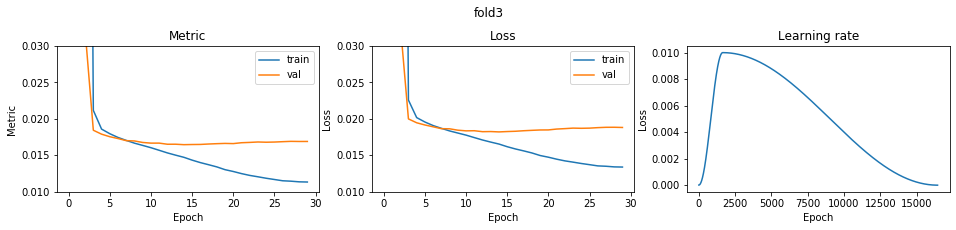

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.744898,0.7448975416,0.686216,0.6862112097,0:6
2,0.647884,0.6478571495,0.515682,0.5155830518,0:5
3,0.194154,0.1936635502,0.034022,0.0330614671,0:5
4,0.022728,0.0213178730,0.019993,0.0184532240,0:5
5,0.020253,0.0186793903,0.019380,0.0178050837,0:5
6,0.019684,0.0180782552,0.019087,0.0174761883,0:5
7,0.019272,0.0176412975,0.018927,0.0173166230,0:6
8,0.018867,0.0172166819,0.018623,0.0169905848,0:6
9,0.018574,0.0169020464,0.018564,0.0169266603,0:6
10,0.018185,0.0164879959,0.018447,0.0167821828,0:6


epoch1 save best model... 0.6862112096610536
epoch2 save best model... 0.5155830517716723
epoch3 save best model... 0.03306146709159322
epoch4 save best model... 0.018453224019013805
epoch5 save best model... 0.01780508367476268
epoch6 save best model... 0.01747618832059018
epoch7 save best model... 0.01731662303718456
epoch8 save best model... 0.01699058480883242
epoch9 save best model... 0.01692666029196937
epoch10 save best model... 0.016782182813590237
epoch11 save best model... 0.016628584966216244
epoch13 save best model... 0.016554062554277566
epoch14 save best model... 0.01651983898693106
epoch18 save best model... 0.016513218166803036
fold4 score: 0.016513217928051292


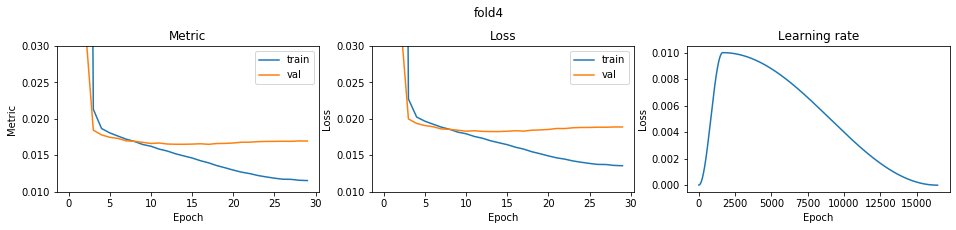

CV score: 0.01646380807642482

optimizer: NovoGrad
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.577546,0.5774125124,0.054131,0.0533410459,0:4
2,0.024933,0.0234611447,0.020694,0.0190954861,0:4
3,0.021167,0.0195656025,0.019692,0.0180815619,0:4
4,0.020359,0.0187345111,0.019195,0.0175806412,0:4
5,0.019848,0.0182022484,0.019066,0.0174085996,0:4
6,0.019419,0.0177553681,0.018684,0.0170334098,0:4
7,0.019134,0.0174531170,0.018543,0.0168594069,0:4
8,0.018829,0.0171287104,0.018408,0.0167133659,0:4
9,0.018556,0.0168418539,0.018319,0.0166211671,0:4
10,0.018311,0.0165805602,0.018234,0.0165516906,0:4


epoch1 save best model... 0.053341045916284135
epoch2 save best model... 0.01909548609277789
epoch3 save best model... 0.0180815619265911
epoch4 save best model... 0.017580641154411984
epoch5 save best model... 0.017408599606068095
epoch6 save best model... 0.017033409791444864
epoch7 save best model... 0.016859406932068305
epoch8 save best model... 0.016713365868310993
epoch9 save best model... 0.01662116710495433
epoch10 save best model... 0.016551690580056035
epoch11 save best model... 0.016425377593411807
epoch12 save best model... 0.01633233989934715
epoch13 save best model... 0.016275726085643292
epoch14 save best model... 0.016228823547924025
epoch16 save best model... 0.016146862845876356
epoch18 save best model... 0.016084250656289635
fold0 score: 0.016084250454568794


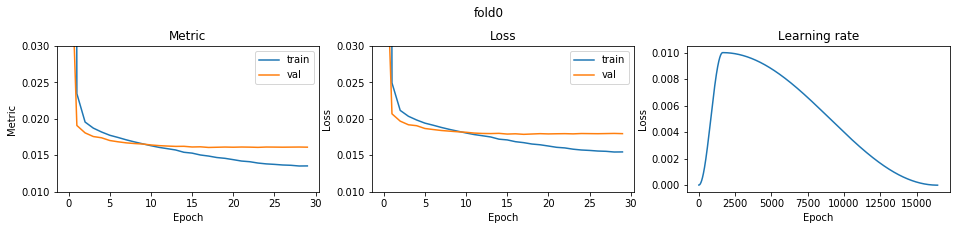

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.575624,0.5754898061,0.056043,0.0552695356,0:5
2,0.025079,0.0236069928,0.020904,0.0193391473,0:4
3,0.021147,0.0195447694,0.019737,0.0181324522,0:4
4,0.020299,0.0186678876,0.019351,0.0177452246,0:4
5,0.019769,0.0181212188,0.019036,0.0173951247,0:4
6,0.019409,0.0177425468,0.018902,0.0172569471,0:4
7,0.019020,0.0173347804,0.018687,0.0170317069,0:4
8,0.018706,0.0170032124,0.018569,0.0169055420,0:4
9,0.018414,0.0166907067,0.018555,0.0168798928,0:4
10,0.018219,0.0164806027,0.018480,0.0167735305,0:4


epoch1 save best model... 0.05526953560717558
epoch2 save best model... 0.01933914734745357
epoch3 save best model... 0.018132452174637523
epoch4 save best model... 0.017745224588802504
epoch5 save best model... 0.01739512471531811
epoch6 save best model... 0.01725694710462199
epoch7 save best model... 0.017031706934533784
epoch8 save best model... 0.01690554204504062
epoch9 save best model... 0.016879892758227245
epoch10 save best model... 0.016773530516979714
epoch11 save best model... 0.016701530852739347
epoch12 save best model... 0.016602261467883694
epoch13 save best model... 0.01658590847749826
epoch14 save best model... 0.016573811299194097
epoch15 save best model... 0.016538982398215555
epoch16 save best model... 0.016502786433253345
epoch17 save best model... 0.016469355240357263
epoch18 save best model... 0.01646425528504849
epoch19 save best model... 0.016461086775415794
epoch20 save best model... 0.016438204593749367
fold1 score: 0.01643820451458309


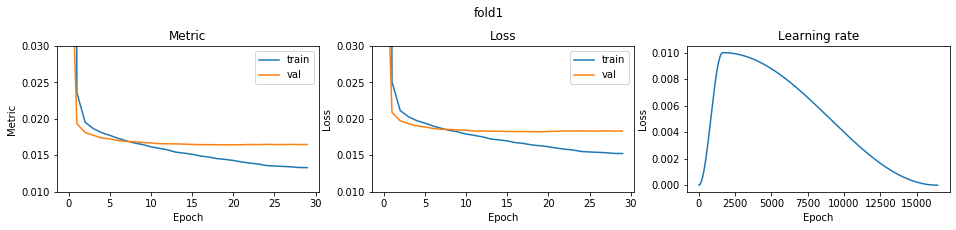

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.574546,0.5744113887,0.054235,0.0534510198,0:4
2,0.024855,0.0233825192,0.020882,0.0193059193,0:4
3,0.021213,0.0196119273,0.019725,0.0181208710,0:4
4,0.020347,0.0187208147,0.019311,0.0176748358,0:4
5,0.019850,0.0182042579,0.019038,0.0174270943,0:4
6,0.019435,0.0177721258,0.018847,0.0172059842,0:4
7,0.019168,0.0174874744,0.018591,0.0169324657,0:4
8,0.018805,0.0171078455,0.018499,0.0168284921,0:5
9,0.018570,0.0168583666,0.018345,0.0166591453,0:5
10,0.018334,0.0166064085,0.018317,0.0165997457,0:4


epoch1 save best model... 0.053451019754528484
epoch2 save best model... 0.019305919298949262
epoch3 save best model... 0.018120870982142073
epoch4 save best model... 0.01767483579899244
epoch5 save best model... 0.017427094345439143
epoch6 save best model... 0.017205984211565217
epoch7 save best model... 0.016932465682452554
epoch8 save best model... 0.01682849212085557
epoch9 save best model... 0.01665914532155355
epoch10 save best model... 0.01659974565707855
epoch11 save best model... 0.016426623439873358
epoch12 save best model... 0.01633391128231233
epoch15 save best model... 0.01631291327761657
epoch16 save best model... 0.016265658350221306
epoch17 save best model... 0.0162349995826179
epoch18 save best model... 0.01621447601218747
epoch19 save best model... 0.016196943815703354
epoch26 save best model... 0.016190462091529825
fold2 score: 0.016190461963397615


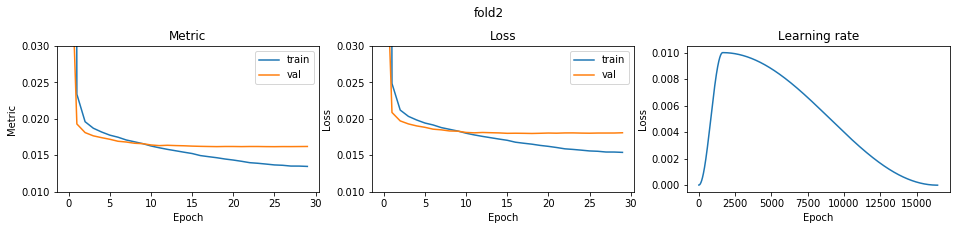

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.578524,0.5783914695,0.056429,0.0556569597,0:4
2,0.024973,0.0235026984,0.020916,0.0193321006,0:4
3,0.021135,0.0195309875,0.019799,0.0181936816,0:4
4,0.020286,0.0186572010,0.019393,0.0177880053,0:4
5,0.019833,0.0181862351,0.019177,0.0175269332,0:4
6,0.019390,0.0177241494,0.018934,0.0172802184,0:4
7,0.019037,0.0173531353,0.018777,0.0171221604,0:4
8,0.018741,0.0170398988,0.018598,0.0169188177,0:4
9,0.018475,0.0167567626,0.018518,0.0168478508,0:4
10,0.018240,0.0165050486,0.018390,0.0166806204,0:4


epoch1 save best model... 0.055656959654462095
epoch2 save best model... 0.01933210060034363
epoch3 save best model... 0.018193681637813805
epoch4 save best model... 0.01778800527274541
epoch5 save best model... 0.017526933217764853
epoch6 save best model... 0.017280218426078763
epoch7 save best model... 0.017122160446891615
epoch8 save best model... 0.016918817654693316
epoch9 save best model... 0.01684785080831795
epoch10 save best model... 0.01668062041935793
epoch11 save best model... 0.016648996712593254
epoch12 save best model... 0.016575405789551946
epoch13 save best model... 0.016542728838843883
epoch14 save best model... 0.01648575878852728
epoch15 save best model... 0.016480924758491593
epoch16 save best model... 0.01645542011301379
epoch17 save best model... 0.01639190295282624
epoch18 save best model... 0.016371793262575644
epoch19 save best model... 0.016347500941544295
epoch21 save best model... 0.01632534886852484
fold3 score: 0.016325348896574166


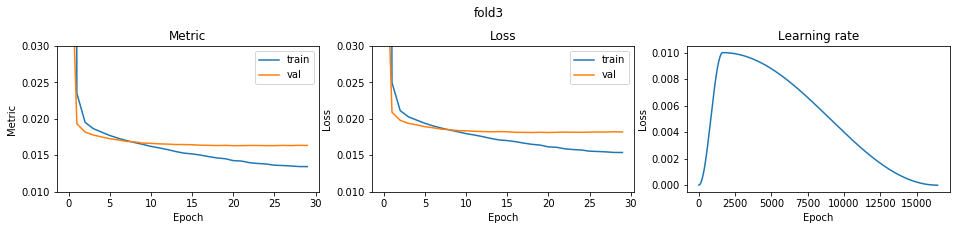

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.576685,0.5765510981,0.056178,0.0554082812,0:4
2,0.024962,0.0234893718,0.020441,0.0188685036,0:4
3,0.021277,0.0196750022,0.019646,0.0180425587,0:4
4,0.020358,0.0187323637,0.019251,0.0176538413,0:4
5,0.019842,0.0181950703,0.019022,0.0173952943,0:4
6,0.019439,0.0177766217,0.018743,0.0171064012,0:4
7,0.019061,0.0173756401,0.018602,0.0169482405,0:4
8,0.018759,0.0170570294,0.018533,0.0168596666,0:4
9,0.018532,0.0168170200,0.018399,0.0167173954,0:4
10,0.018286,0.0165528463,0.018386,0.0166657644,0:4


epoch1 save best model... 0.055408281174431084
epoch2 save best model... 0.018868503588037502
epoch3 save best model... 0.018042558717598675
epoch4 save best model... 0.017653841295773864
epoch5 save best model... 0.017395294347782204
epoch6 save best model... 0.0171064012070825
epoch7 save best model... 0.016948240479467126
epoch8 save best model... 0.016859666550010102
epoch9 save best model... 0.016717395362930036
epoch10 save best model... 0.016665764447038565
epoch11 save best model... 0.016560342894752503
epoch12 save best model... 0.016522556375754584
epoch13 save best model... 0.0164555554360932
epoch14 save best model... 0.01640383503261894
epoch15 save best model... 0.016397016422487882
epoch16 save best model... 0.016370885008373266
epoch17 save best model... 0.01636036905356108
epoch18 save best model... 0.016329870212203685
epoch22 save best model... 0.01632656929271979
epoch23 save best model... 0.016319725265756146
fold4 score: 0.01631972522483864


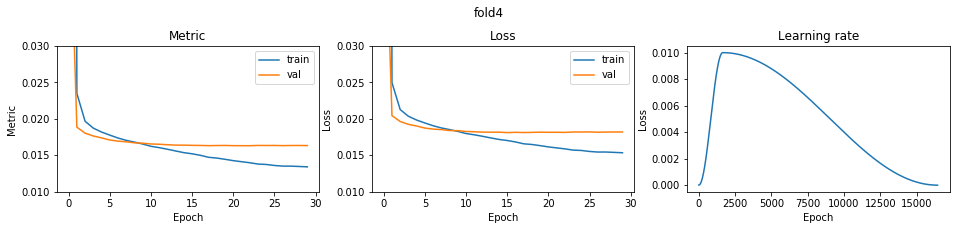

CV score: 0.01627159431658541

optimizer: QHAdam
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.442185,0.4417719842,0.024479,0.0230915698,0:4
2,0.024063,0.0224742483,0.020902,0.0191761365,0:4
3,0.022717,0.0210013855,0.020092,0.0183746756,0:4
4,0.021532,0.0198159751,0.019595,0.0178855331,0:4
5,0.020688,0.0189960000,0.019231,0.0175298099,0:4
6,0.020326,0.0186435753,0.019110,0.0174262334,0:4
7,0.020015,0.0183275823,0.018913,0.0172239870,0:4
8,0.019825,0.0181343375,0.018827,0.0171689233,0:4
9,0.019818,0.0181257238,0.018807,0.0171259095,0:4
10,0.019757,0.0180565403,0.018791,0.0171034826,0:4


epoch1 save best model... 0.02309156976775998
epoch2 save best model... 0.019176136537673534
epoch3 save best model... 0.018374675575957754
epoch4 save best model... 0.017885533124547884
epoch5 save best model... 0.017529809859354296
epoch6 save best model... 0.0174262334119554
epoch7 save best model... 0.01722398696717613
epoch8 save best model... 0.017168923344352795
epoch9 save best model... 0.017125909522617052
epoch10 save best model... 0.017103482582574554
epoch12 save best model... 0.01708558719511863
epoch13 save best model... 0.017046282313984727
epoch16 save best model... 0.01696444453166666
epoch17 save best model... 0.016898852871022354
epoch18 save best model... 0.01680542413306535
epoch19 save best model... 0.016646713615821544
epoch21 save best model... 0.01648462414826375
epoch22 save best model... 0.016399735676926604
epoch23 save best model... 0.016257443556515393
epoch25 save best model... 0.01615005089203426
fold0 score: 0.016150050940070933


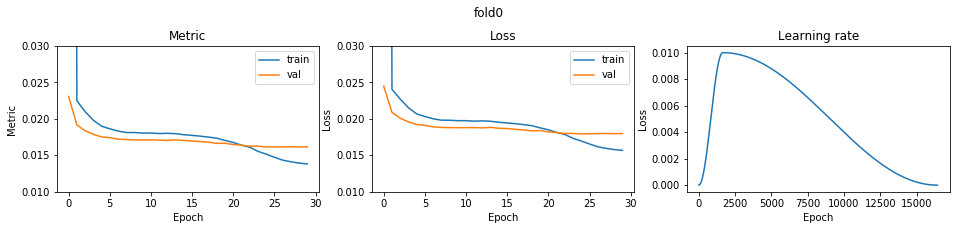

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.441818,0.4414052349,0.023434,0.0220636325,0:4
2,0.024299,0.0227028377,0.021183,0.0195116815,0:4
3,0.022766,0.0210381775,0.020253,0.0185289806,0:4
4,0.021487,0.0197716634,0.019611,0.0179104140,0:4
5,0.020587,0.0188893925,0.019599,0.0179119020,0:4
6,0.020186,0.0184978341,0.019324,0.0176522656,0:4
7,0.019838,0.0181441335,0.019095,0.0174140800,0:4
8,0.019752,0.0180554714,0.018924,0.0172766563,0:4
9,0.019684,0.0179838973,0.019059,0.0173764414,0:4
10,0.019667,0.0179661823,0.018966,0.0172951115,0:4


epoch1 save best model... 0.02206363247766476
epoch2 save best model... 0.019511681452383346
epoch3 save best model... 0.018528980558399025
epoch4 save best model... 0.01791041397919726
epoch6 save best model... 0.017652265647522584
epoch7 save best model... 0.017414080032959536
epoch8 save best model... 0.017276656257757213
epoch12 save best model... 0.01723952693102924
epoch16 save best model... 0.017232753109381257
epoch17 save best model... 0.017187238134245147
epoch18 save best model... 0.017038256975854617
epoch19 save best model... 0.01695805527995546
epoch20 save best model... 0.01695397420172866
epoch21 save best model... 0.01684823531447809
epoch22 save best model... 0.01662891731769573
epoch23 save best model... 0.016591629102965317
epoch24 save best model... 0.016537643646098645
epoch25 save best model... 0.016519522724520796
epoch27 save best model... 0.01648640715618745
epoch28 save best model... 0.016482745818403335
fold1 score: 0.016482745826966207


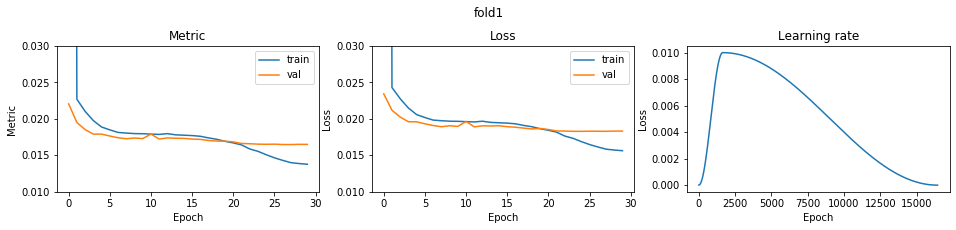

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.441342,0.4409270858,0.024330,0.0229755353,0:4
2,0.024214,0.0226140761,0.021002,0.0193216932,0:4
3,0.022604,0.0208923533,0.020122,0.0184181744,0:4
4,0.021518,0.0198122268,0.019522,0.0178473209,0:4
5,0.020604,0.0189111069,0.019263,0.0176087850,0:4
6,0.020171,0.0184853244,0.019150,0.0174766740,0:4
7,0.019922,0.0182285147,0.019140,0.0174775437,0:4
8,0.019868,0.0181763976,0.019005,0.0173436745,0:4
9,0.019736,0.0180373398,0.018908,0.0172507732,0:4
10,0.019694,0.0179938283,0.018850,0.0171563130,0:4


epoch1 save best model... 0.022975535337183193
epoch2 save best model... 0.01932169322334408
epoch3 save best model... 0.018418174419288117
epoch4 save best model... 0.017847320893734836
epoch5 save best model... 0.017608784967352287
epoch6 save best model... 0.017476673980448696
epoch8 save best model... 0.017343674492499205
epoch9 save best model... 0.017250773182241077
epoch10 save best model... 0.017156312968492793
epoch12 save best model... 0.01714388463191228
epoch13 save best model... 0.01714248700552478
epoch14 save best model... 0.017045772781073165
epoch15 save best model... 0.0170046465403909
epoch17 save best model... 0.01690698682936789
epoch18 save best model... 0.016795279748235335
epoch19 save best model... 0.016750734710230267
epoch20 save best model... 0.01657448050570898
epoch21 save best model... 0.016489732413414563
epoch22 save best model... 0.016431251215909968
epoch23 save best model... 0.01635867754652278
epoch24 save best model... 0.016219945228303192
epoch25 

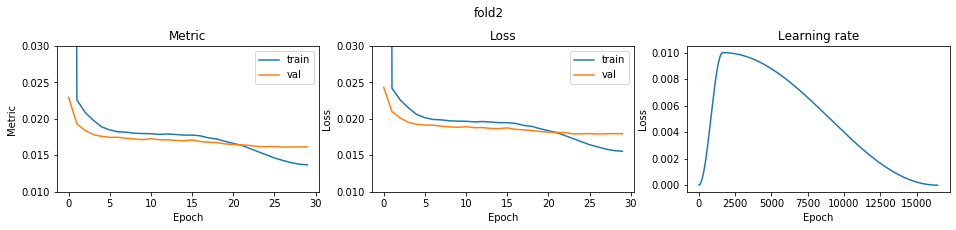

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.440523,0.4401099007,0.023836,0.0225038615,0:4
2,0.024077,0.0224839318,0.021472,0.0197936159,0:4
3,0.022660,0.0209384942,0.020241,0.0185344049,0:4
4,0.021326,0.0196209880,0.019823,0.0181429981,0:4
5,0.020555,0.0188682994,0.019490,0.0178543374,0:4
6,0.020132,0.0184482576,0.019202,0.0175389729,0:4
7,0.019914,0.0182253464,0.019275,0.0175793551,0:4
8,0.019802,0.0181063475,0.019200,0.0175547722,0:4
9,0.019674,0.0179732364,0.019135,0.0174471430,0:4
10,0.019664,0.0179595294,0.018942,0.0172804524,0:4


epoch1 save best model... 0.02250386147180695
epoch2 save best model... 0.019793615887336146
epoch3 save best model... 0.01853440486548091
epoch4 save best model... 0.01814299810312875
epoch5 save best model... 0.017854337411209228
epoch6 save best model... 0.01753897289353039
epoch9 save best model... 0.017447142979736888
epoch10 save best model... 0.017280452445590688
epoch14 save best model... 0.01727075683534281
epoch16 save best model... 0.01716109516485202
epoch17 save best model... 0.01714101174298954
epoch18 save best model... 0.01699165946131483
epoch19 save best model... 0.016841283924707927
epoch20 save best model... 0.01672503924281559
epoch22 save best model... 0.016622670459855934
epoch23 save best model... 0.016526460613215294
epoch24 save best model... 0.016488061284811867
epoch25 save best model... 0.016441096485950952
epoch26 save best model... 0.016427048170569954
epoch27 save best model... 0.0163979023173112
fold3 score: 0.016397902301160592


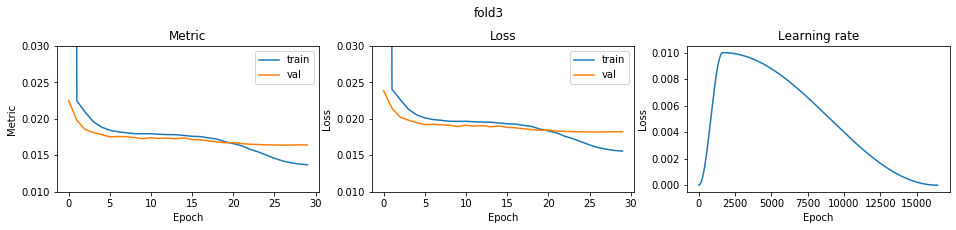

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.443924,0.4435140296,0.023830,0.0224665352,0:4
2,0.024330,0.0227361364,0.020722,0.0190774634,0:4
3,0.022781,0.0210660846,0.020671,0.0189715754,0:4
4,0.021590,0.0198723472,0.019627,0.0179633962,0:4
5,0.020663,0.0189671294,0.019192,0.0175321635,0:4
6,0.020229,0.0185425921,0.019107,0.0174242672,0:4
7,0.019979,0.0182886597,0.018960,0.0172979111,0:4
8,0.019731,0.0180366340,0.019002,0.0173090641,0:4
9,0.019705,0.0180066803,0.018988,0.0173140267,0:4
10,0.019636,0.0179292569,0.018936,0.0172818358,0:4


epoch1 save best model... 0.02246653515090296
epoch2 save best model... 0.01907746339288958
epoch3 save best model... 0.018971575357461166
epoch4 save best model... 0.017963396186318783
epoch5 save best model... 0.017532163544861357
epoch6 save best model... 0.017424267153245035
epoch7 save best model... 0.017297911097068585
epoch10 save best model... 0.017281835772317743
epoch12 save best model... 0.017184761207304673
epoch14 save best model... 0.017046298101493464
epoch16 save best model... 0.016918345350678796
epoch20 save best model... 0.0166807228962388
epoch22 save best model... 0.016641813819137548
epoch23 save best model... 0.0165566357064797
epoch24 save best model... 0.01645350447582221
epoch25 save best model... 0.016432847189960964
epoch27 save best model... 0.0163802639146363
fold4 score: 0.01638026385693788


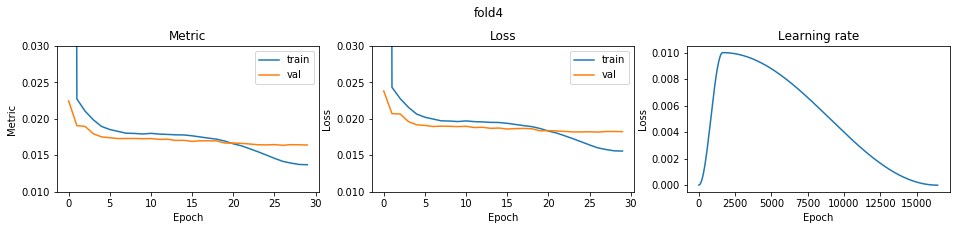

CV score: 0.016309471055374808

optimizer: RAdam
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.595259,0.5951177734,0.036890,0.0359387523,0:4
2,0.026888,0.0254581218,0.021915,0.0202786934,0:4
3,0.023281,0.0215881037,0.020476,0.0187288634,0:4
4,0.021923,0.0201929116,0.019683,0.0179468745,0:4
5,0.021023,0.0193008104,0.019480,0.0177414794,0:4
6,0.020423,0.0187096439,0.019141,0.0174225434,0:4
7,0.020085,0.0183849764,0.018932,0.0172056588,0:4
8,0.019708,0.0180001093,0.018949,0.0172350606,0:4
9,0.019543,0.0178258323,0.018721,0.0170088702,0:4
10,0.019434,0.0177068889,0.018681,0.0169204353,0:4


epoch1 save best model... 0.03593875229664164
epoch2 save best model... 0.020278693365616246
epoch3 save best model... 0.018728863404626726
epoch4 save best model... 0.017946874505600518
epoch5 save best model... 0.017741479390302933
epoch6 save best model... 0.017422543421964712
epoch7 save best model... 0.01720565876463144
epoch9 save best model... 0.017008870172235853
epoch10 save best model... 0.016920435293694292
epoch11 save best model... 0.016893139644472907
epoch12 save best model... 0.01676859616011313
epoch13 save best model... 0.016675077002402183
epoch14 save best model... 0.01667012634574688
epoch16 save best model... 0.0165164880293309
epoch18 save best model... 0.016449400465214172
epoch19 save best model... 0.016346364059742192
epoch20 save best model... 0.016289591622922848
fold0 score: 0.016289591466300178


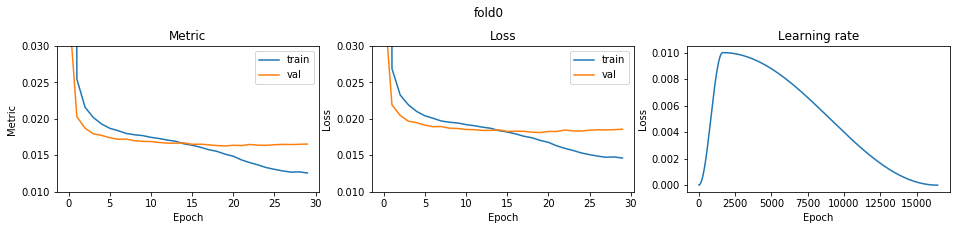

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.593968,0.5938271582,0.040248,0.0393099988,0:4
2,0.026912,0.0254772801,0.021530,0.0198756088,0:4
3,0.022932,0.0212293400,0.020311,0.0185975501,0:4
4,0.021959,0.0202208127,0.019929,0.0181990814,0:4
5,0.021131,0.0194025332,0.019654,0.0179329870,0:4
6,0.020369,0.0186538206,0.019212,0.0175152562,0:4
7,0.019965,0.0182586011,0.019256,0.0175637167,0:4
8,0.019668,0.0179545698,0.019056,0.0173246508,0:4
9,0.019479,0.0177577604,0.019080,0.0173655050,0:4
10,0.019314,0.0175830454,0.018979,0.0172705247,0:4


epoch1 save best model... 0.039309998784502
epoch2 save best model... 0.019875608796691344
epoch3 save best model... 0.018597550062077767
epoch4 save best model... 0.018199081433562216
epoch5 save best model... 0.017932987023093185
epoch6 save best model... 0.01751525622811003
epoch8 save best model... 0.017324650754583847
epoch10 save best model... 0.017270524736547298
epoch11 save best model... 0.01712197750105717
epoch12 save best model... 0.017076722266673228
epoch13 save best model... 0.016920143798864508
epoch15 save best model... 0.01684360275132886
epoch16 save best model... 0.01678433968231683
epoch17 save best model... 0.016719817222531238
epoch18 save best model... 0.016624547086196057
epoch19 save best model... 0.016589862594750617
fold1 score: 0.016589862461199388


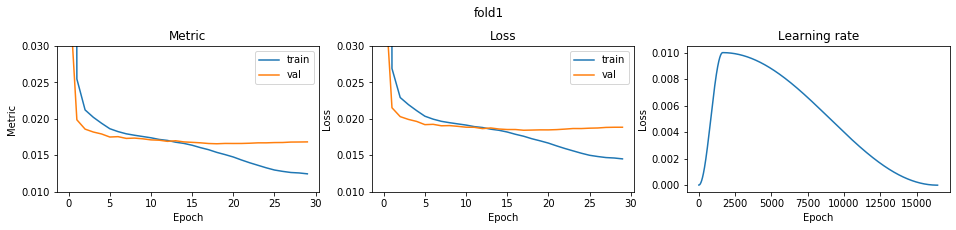

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.591072,0.5909287200,0.040431,0.0395074690,0:4
2,0.026890,0.0254588590,0.022960,0.0213340541,0:4
3,0.022932,0.0212286120,0.020712,0.0190211195,0:4
4,0.021856,0.0201102992,0.019768,0.0180370993,0:4
5,0.021023,0.0192862895,0.019473,0.0177615103,0:4
6,0.020397,0.0186748720,0.019146,0.0174107459,0:4
7,0.020054,0.0183431564,0.019045,0.0173065319,0:4
8,0.019752,0.0180453745,0.018909,0.0171874801,0:4
9,0.019479,0.0177547126,0.018725,0.0170228835,0:4
10,0.019258,0.0175232340,0.018796,0.0170852998,0:4


epoch1 save best model... 0.039507468955667285
epoch2 save best model... 0.021334054109789592
epoch3 save best model... 0.01902111947488088
epoch4 save best model... 0.01803709930061486
epoch5 save best model... 0.01776151030412885
epoch6 save best model... 0.017410745945249637
epoch7 save best model... 0.01730653194795066
epoch8 save best model... 0.017187480069527146
epoch9 save best model... 0.017022883528230278
epoch11 save best model... 0.016922730700838374
epoch12 save best model... 0.016832022094837244
epoch14 save best model... 0.01681826995631799
epoch15 save best model... 0.016542386842900485
epoch18 save best model... 0.01649311216945738
epoch19 save best model... 0.016437339669445307
epoch20 save best model... 0.016362035071138207
epoch22 save best model... 0.016349795781369632
fold2 score: 0.01634979554069744


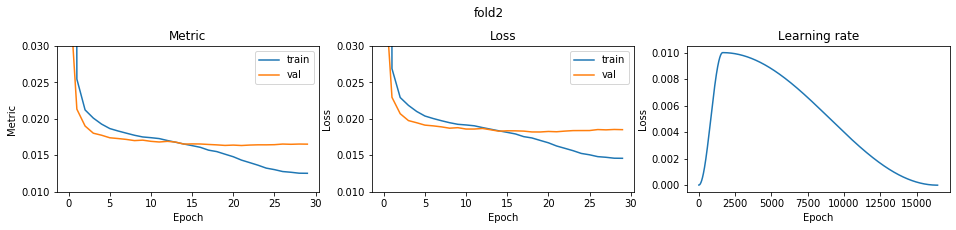

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.593047,0.5929051525,0.038855,0.0379223218,0:4
2,0.026612,0.0251791320,0.021753,0.0200978933,0:4
3,0.022915,0.0211979293,0.020461,0.0187379383,0:4
4,0.021872,0.0201269566,0.020085,0.0183519487,0:4
5,0.020986,0.0192581467,0.019532,0.0178359694,0:4
6,0.020325,0.0186091412,0.019251,0.0175534767,0:4
7,0.019925,0.0182163796,0.019288,0.0175998400,0:4
8,0.019713,0.0179990204,0.019066,0.0173595133,0:4
9,0.019471,0.0177506318,0.018933,0.0172815357,0:4
10,0.019229,0.0174916791,0.019077,0.0173186925,0:4


epoch1 save best model... 0.03792232179458429
epoch2 save best model... 0.02009789330676911
epoch3 save best model... 0.01873793829368228
epoch4 save best model... 0.018351948702949733
epoch5 save best model... 0.017835969376061665
epoch6 save best model... 0.017553476731723562
epoch8 save best model... 0.017359513297235774
epoch9 save best model... 0.01728153572818752
epoch11 save best model... 0.017016623181488222
epoch13 save best model... 0.016950022756781827
epoch15 save best model... 0.016805333820657468
epoch16 save best model... 0.016730814567578273
epoch18 save best model... 0.016610628864165727
epoch20 save best model... 0.01659873165487225
epoch21 save best model... 0.016510042370400966
fold3 score: 0.01651004221915796


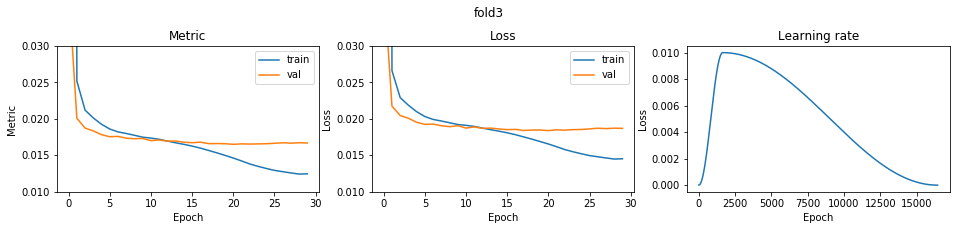

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.590675,0.5905302859,0.040384,0.0394487877,0:4
2,0.026878,0.0254429835,0.021310,0.0196807096,0:4
3,0.023129,0.0214258372,0.020379,0.0186282339,0:4
4,0.022113,0.0203634077,0.019829,0.0180896561,0:4
5,0.021112,0.0193782214,0.019353,0.0176433343,0:4
6,0.020493,0.0187793669,0.019260,0.0175285342,0:4
7,0.020009,0.0183001373,0.018959,0.0172564271,0:4
8,0.019791,0.0180810225,0.018773,0.0171105909,0:4
9,0.019555,0.0178396628,0.018968,0.0172244178,0:4
10,0.019379,0.0176449050,0.018815,0.0171309132,0:4


epoch1 save best model... 0.039448787711543754
epoch2 save best model... 0.019680709584461258
epoch3 save best model... 0.018628233865938724
epoch4 save best model... 0.018089656116852457
epoch5 save best model... 0.017643334294387174
epoch6 save best model... 0.017528534234248966
epoch7 save best model... 0.017256427142590895
epoch8 save best model... 0.017110590907853256
epoch11 save best model... 0.016889624353201217
epoch14 save best model... 0.016838172629288904
epoch15 save best model... 0.016693301110237767
epoch16 save best model... 0.016626723733961853
epoch17 save best model... 0.016591094212356217
epoch18 save best model... 0.01654640128645104
epoch19 save best model... 0.01651714944019744
epoch20 save best model... 0.016425881924739868
fold4 score: 0.01642588179626658


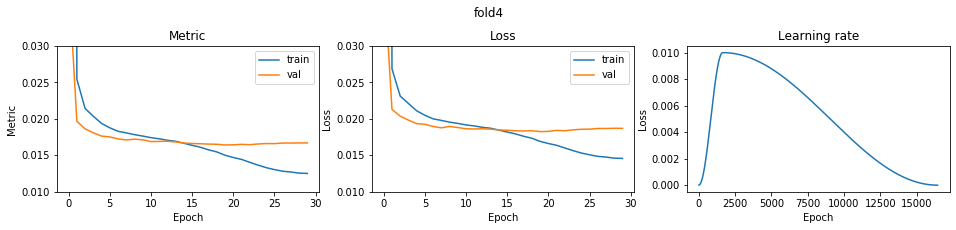

CV score: 0.016433031343862616

optimizer: Ranger
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.697107,0.6970751636,0.255139,0.2548205042,0:4
2,0.051405,0.0502651961,0.022913,0.0213632910,0:4
3,0.023434,0.0218060094,0.020772,0.0191046383,0:4
4,0.022122,0.0204093084,0.019863,0.0181353359,0:4
5,0.021433,0.0196906169,0.019626,0.0178921503,0:4
6,0.020902,0.0191533378,0.019121,0.0173816651,0:4
7,0.020473,0.0187175725,0.019117,0.0173620192,0:4
8,0.020065,0.0183109435,0.018921,0.0171594278,0:4
9,0.019670,0.0179112075,0.018615,0.0168704808,0:4
10,0.019347,0.0175925424,0.018660,0.0169024463,0:4


epoch1 save best model... 0.25482050418039115
epoch2 save best model... 0.021363290974653934
epoch3 save best model... 0.019104638302821775
epoch4 save best model... 0.01813533589464521
epoch5 save best model... 0.017892150270300736
epoch6 save best model... 0.017381665136045638
epoch7 save best model... 0.01736201919649212
epoch8 save best model... 0.017159427783891117
epoch9 save best model... 0.01687048082080816
epoch11 save best model... 0.016764173898548906
epoch12 save best model... 0.01665909073500128
epoch13 save best model... 0.01650483584061163
epoch14 save best model... 0.016436128929291336
epoch15 save best model... 0.016312192428373395
epoch16 save best model... 0.01627792588441478
epoch17 save best model... 0.01622826404665896
epoch19 save best model... 0.016173129039551374
fold0 score: 0.016173128912724852


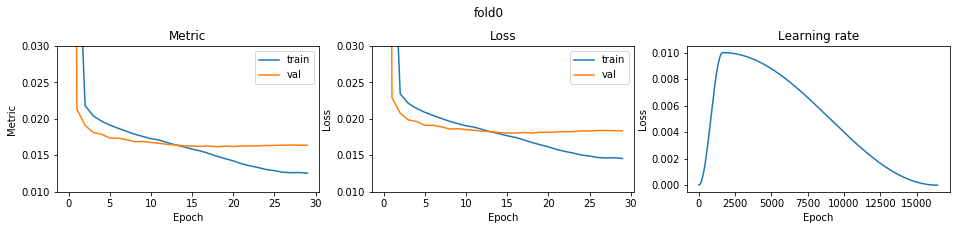

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.696111,0.6960781861,0.251024,0.2507036744,0:4
2,0.050888,0.0497464961,0.022407,0.0208992348,0:4
3,0.023237,0.0216151601,0.020607,0.0189618570,0:4
4,0.021914,0.0202123767,0.019945,0.0182647665,0:4
5,0.021217,0.0194905503,0.019719,0.0180099374,0:4
6,0.020661,0.0189236796,0.019282,0.0175590841,0:4
7,0.020295,0.0185505937,0.019197,0.0174894618,0:4
8,0.019853,0.0181059919,0.019133,0.0174105729,0:4
9,0.019468,0.0177140434,0.018785,0.0170851255,0:4
10,0.019192,0.0174418578,0.018677,0.0169567501,0:4


epoch1 save best model... 0.25070367440815583
epoch2 save best model... 0.020899234789023235
epoch3 save best model... 0.018961856987494547
epoch4 save best model... 0.018264766546561687
epoch5 save best model... 0.018009937427960053
epoch6 save best model... 0.017559084086620567
epoch7 save best model... 0.01748946180839179
epoch8 save best model... 0.01741057294863324
epoch9 save best model... 0.01708512551620803
epoch10 save best model... 0.01695675006415122
epoch12 save best model... 0.01678452287892066
epoch14 save best model... 0.016712386073240333
epoch15 save best model... 0.016657580897605863
epoch16 save best model... 0.016634444614473835
epoch17 save best model... 0.016607982542779145
epoch18 save best model... 0.01658708278826502
fold1 score: 0.016587082684637287


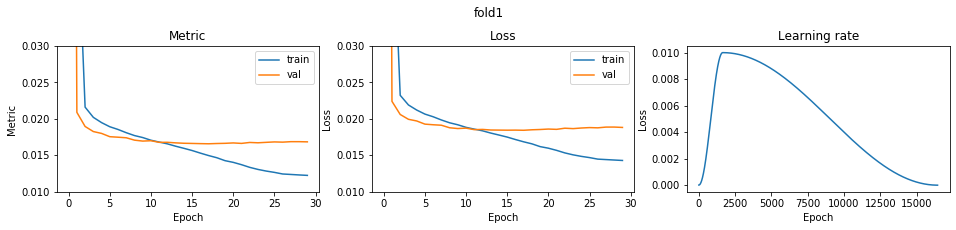

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.698582,0.6985501844,0.262020,0.2617116608,0:4
2,0.051788,0.0506459088,0.022578,0.0210416581,0:4
3,0.023153,0.0215323954,0.020685,0.0190274262,0:4
4,0.021985,0.0202692572,0.019916,0.0181930936,0:4
5,0.021298,0.0195602776,0.019630,0.0179259481,0:4
6,0.020703,0.0189532804,0.019064,0.0173615194,0:4
7,0.020261,0.0185062978,0.019060,0.0173377971,0:4
8,0.019877,0.0181157765,0.018942,0.0172053331,0:4
9,0.019565,0.0178042956,0.018591,0.0168482647,0:4
10,0.019194,0.0174308271,0.018500,0.0167810034,0:4


epoch1 save best model... 0.2617116608498009
epoch2 save best model... 0.02104165805743506
epoch3 save best model... 0.019027426156881026
epoch4 save best model... 0.018193093601696568
epoch5 save best model... 0.017925948059701123
epoch6 save best model... 0.017361519442763842
epoch7 save best model... 0.01733779711158652
epoch8 save best model... 0.017205333068124877
epoch9 save best model... 0.016848264742489013
epoch10 save best model... 0.01678100344401356
epoch11 save best model... 0.01677706604070179
epoch12 save best model... 0.016631396556318512
epoch13 save best model... 0.016605124347748804
epoch14 save best model... 0.016461257109625187
epoch15 save best model... 0.016382521039393163
epoch16 save best model... 0.016371230706640434
epoch17 save best model... 0.01634256386635861
epoch18 save best model... 0.01631144540162456
fold2 score: 0.016311445202272363


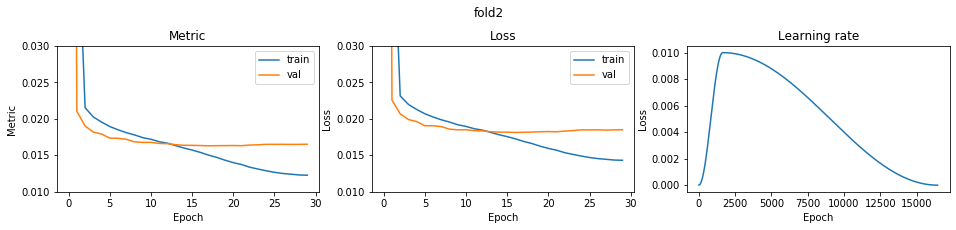

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.697971,0.6979402575,0.258656,0.2583441069,0:4
2,0.053077,0.0519420873,0.022456,0.0209493697,0:4
3,0.023452,0.0218256323,0.021001,0.0193247013,0:4
4,0.022033,0.0203292896,0.020015,0.0183093423,0:4
5,0.021277,0.0195462952,0.019931,0.0181730691,0:4
6,0.020777,0.0190242428,0.019397,0.0176669836,0:4
7,0.020337,0.0185776405,0.019220,0.0174448292,0:4
8,0.019915,0.0181536189,0.019348,0.0175688967,0:4
9,0.019582,0.0178215466,0.018996,0.0172581305,0:4
10,0.019268,0.0175031755,0.018946,0.0171991901,0:4


epoch1 save best model... 0.2583441068547733
epoch2 save best model... 0.020949369735150238
epoch3 save best model... 0.019324701256914264
epoch4 save best model... 0.01830934227395438
epoch5 save best model... 0.018173069065194874
epoch6 save best model... 0.017666983580246466
epoch7 save best model... 0.017444829183263632
epoch9 save best model... 0.01725813053964143
epoch10 save best model... 0.017199190137462354
epoch11 save best model... 0.016984327406047554
epoch12 save best model... 0.016852415213891747
epoch13 save best model... 0.016799384814629795
epoch14 save best model... 0.016776168795731045
epoch15 save best model... 0.016702134818568453
epoch16 save best model... 0.01661990723808154
epoch17 save best model... 0.016552892874222003
epoch18 save best model... 0.016520706369437633
epoch19 save best model... 0.01652063020719279
epoch21 save best model... 0.01650016374656918
fold3 score: 0.016500163625382064


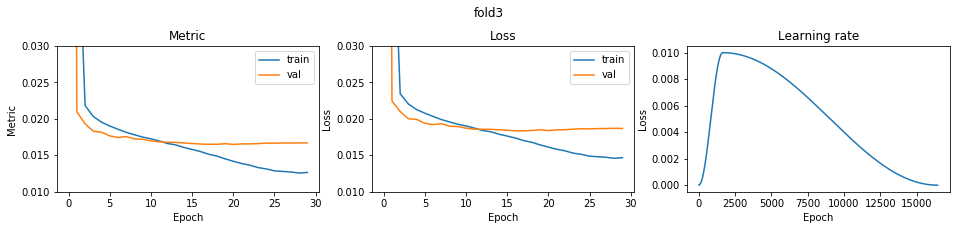

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.698151,0.6981199571,0.264979,0.2646732411,0:4
2,0.051722,0.0505819416,0.022068,0.0205546210,0:4
3,0.023335,0.0217118340,0.020367,0.0186974710,0:4
4,0.022260,0.0205474784,0.019947,0.0181904740,0:4
5,0.021479,0.0197383697,0.019538,0.0178343596,0:4
6,0.020750,0.0190083233,0.019062,0.0173684468,0:4
7,0.020356,0.0186091918,0.019080,0.0173556200,0:4
8,0.019967,0.0182163043,0.019061,0.0173160484,0:4
9,0.019619,0.0178723965,0.018777,0.0170368191,0:4
10,0.019323,0.0175716867,0.018625,0.0169261951,0:4


epoch1 save best model... 0.2646732410700283
epoch2 save best model... 0.02055462096522908
epoch3 save best model... 0.018697470971351333
epoch4 save best model... 0.018190473976602315
epoch5 save best model... 0.017834359609812566
epoch6 save best model... 0.017368446755093567
epoch7 save best model... 0.017355620022226712
epoch8 save best model... 0.017316048380606946
epoch9 save best model... 0.01703681912833235
epoch10 save best model... 0.016926195066855002
epoch11 save best model... 0.016856429391542707
epoch12 save best model... 0.016817122879003204
epoch13 save best model... 0.01667958568391265
epoch15 save best model... 0.016607541790770914
epoch16 save best model... 0.016569001802958224
epoch17 save best model... 0.01653434339537368
fold4 score: 0.016534343259187824


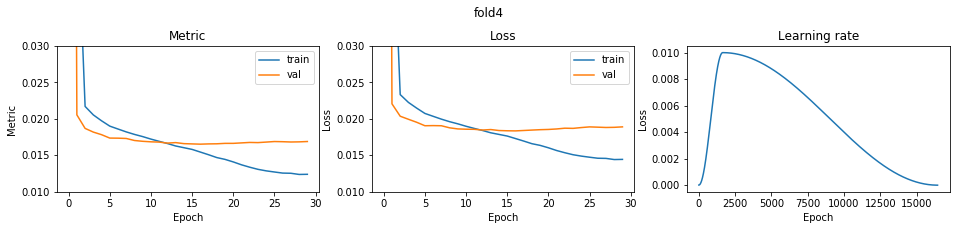

CV score: 0.016421230182511865

optimizer: RangerQH
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.537701,0.5374937945,0.034035,0.0330157166,0:4
2,0.026381,0.0249560587,0.022241,0.0205891161,0:4
3,0.023066,0.0213765932,0.020555,0.0188130410,0:4
4,0.021807,0.0200821451,0.019440,0.0177442446,0:4
5,0.021192,0.0194638771,0.019380,0.0176661373,0:4
6,0.020469,0.0187402817,0.019100,0.0173761129,0:4
7,0.020134,0.0184083294,0.018904,0.0171949289,0:4
8,0.019855,0.0181300755,0.018941,0.0171890531,0:4
9,0.019517,0.0177910346,0.018609,0.0168992260,0:4
10,0.019325,0.0175933228,0.018538,0.0168165364,0:4


epoch1 save best model... 0.033015716637660814
epoch2 save best model... 0.020589116107935516
epoch3 save best model... 0.018813041002746323
epoch4 save best model... 0.017744244605404642
epoch5 save best model... 0.017666137271087644
epoch6 save best model... 0.017376112891255045
epoch7 save best model... 0.01719492887632586
epoch8 save best model... 0.017189053104074505
epoch9 save best model... 0.016899225975817455
epoch10 save best model... 0.016816536436846018
epoch11 save best model... 0.01677068611161448
epoch12 save best model... 0.01660484292359857
epoch14 save best model... 0.0166011714476218
epoch16 save best model... 0.016503998144595525
epoch17 save best model... 0.016434202871469947
epoch18 save best model... 0.016323052049277177
epoch20 save best model... 0.016294286256244486
epoch21 save best model... 0.016197976119952075
epoch22 save best model... 0.016193403809804444
fold0 score: 0.01619340370349825


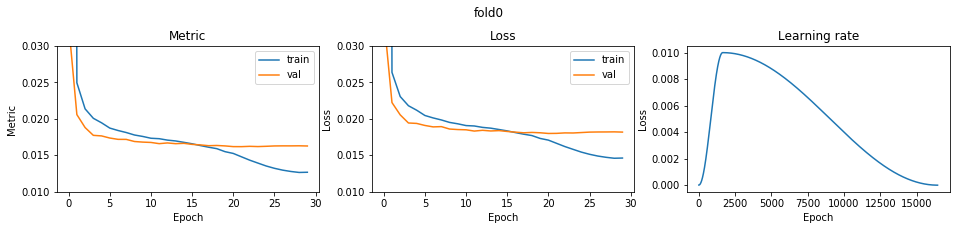

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.535488,0.5352766817,0.032131,0.0310941494,0:4
2,0.026278,0.0248545798,0.022360,0.0207169488,0:4
3,0.022830,0.0211428417,0.020520,0.0187902394,0:4
4,0.021713,0.0199806244,0.019895,0.0181507222,0:4
5,0.020999,0.0192737613,0.019667,0.0179422947,0:4
6,0.020453,0.0187276199,0.019248,0.0175499553,0:4
7,0.019963,0.0182370430,0.019197,0.0174789320,0:4
8,0.019737,0.0180061527,0.019135,0.0174337599,0:4
9,0.019451,0.0177225498,0.018886,0.0171879825,0:4
10,0.019246,0.0175145456,0.018806,0.0170780562,0:4


epoch1 save best model... 0.031094149391657673
epoch2 save best model... 0.02071694884509507
epoch3 save best model... 0.018790239448270595
epoch4 save best model... 0.01815072215387356
epoch5 save best model... 0.017942294665996564
epoch6 save best model... 0.01754995530115143
epoch7 save best model... 0.01747893204067584
epoch8 save best model... 0.01743375990471038
epoch9 save best model... 0.01718798253025735
epoch10 save best model... 0.017078056215338526
epoch12 save best model... 0.01694902997505532
epoch13 save best model... 0.01689824970313033
epoch16 save best model... 0.016784540509330193
epoch17 save best model... 0.01675341999988793
epoch18 save best model... 0.016654228498765807
epoch19 save best model... 0.016632517837505727
epoch21 save best model... 0.016585498286878417
epoch23 save best model... 0.016568887769356014
fold1 score: 0.016568887591591062


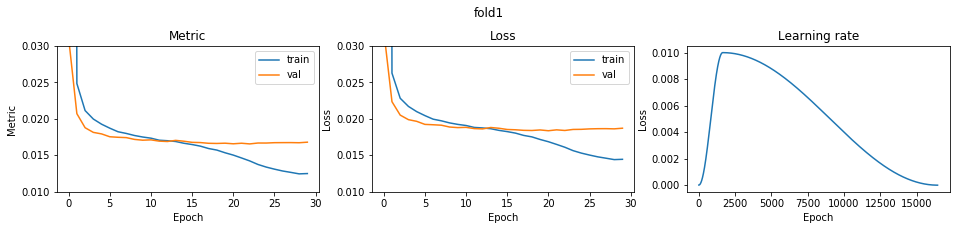

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.536963,0.5367555198,0.033696,0.0326954338,0:4
2,0.026423,0.0249976259,0.021380,0.0197463398,0:4
3,0.022934,0.0212501708,0.020658,0.0188925005,0:4
4,0.021775,0.0200447043,0.019693,0.0179666226,0:4
5,0.021049,0.0193162531,0.019507,0.0177911607,0:4
6,0.020488,0.0187542950,0.019118,0.0174222484,0:4
7,0.020111,0.0183792575,0.019016,0.0172948293,0:4
8,0.019779,0.0180511168,0.018854,0.0171422471,0:4
9,0.019481,0.0177472561,0.018689,0.0169798248,0:4
10,0.019368,0.0176353591,0.018612,0.0169217169,0:4


epoch1 save best model... 0.032695433795859534
epoch2 save best model... 0.01974633978083509
epoch3 save best model... 0.018892500544037762
epoch4 save best model... 0.0179666226369444
epoch5 save best model... 0.01779116070550296
epoch6 save best model... 0.017422248353881602
epoch7 save best model... 0.017294829320030975
epoch8 save best model... 0.017142247077392526
epoch9 save best model... 0.016979824799571528
epoch10 save best model... 0.01692171689542212
epoch12 save best model... 0.016790877541751653
epoch15 save best model... 0.016589445992455473
epoch16 save best model... 0.01656325744334706
epoch17 save best model... 0.01648508499833331
epoch18 save best model... 0.016449544787165867
epoch19 save best model... 0.016370872460224208
epoch20 save best model... 0.016370387260048164
epoch21 save best model... 0.016345031042985396
epoch22 save best model... 0.016311605362059056
fold2 score: 0.016311605251049598


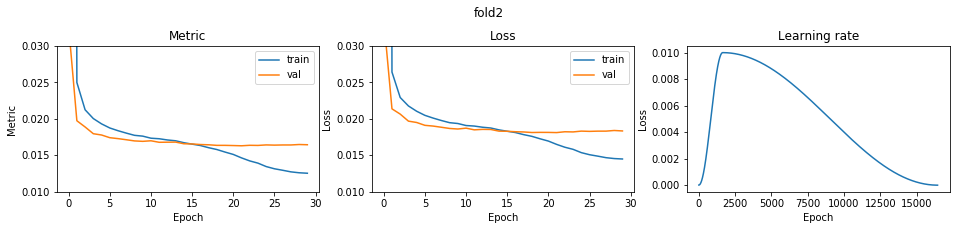

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.537351,0.5371438370,0.034100,0.0331022354,0:4
2,0.026282,0.0248534285,0.021996,0.0203823514,0:4
3,0.022792,0.0211145235,0.020371,0.0186289452,0:4
4,0.021643,0.0199212699,0.019935,0.0181928133,0:4
5,0.020835,0.0191063615,0.019705,0.0179911375,0:4
6,0.020330,0.0185983744,0.019226,0.0175268969,0:4
7,0.019975,0.0182458980,0.019165,0.0174697522,0:4
8,0.019706,0.0179806194,0.019023,0.0173015099,0:4
9,0.019390,0.0176572826,0.018905,0.0172016484,0:4
10,0.019204,0.0174711638,0.018695,0.0169820424,0:4


epoch1 save best model... 0.03310223535331208
epoch2 save best model... 0.020382351442696293
epoch3 save best model... 0.018628945162176135
epoch4 save best model... 0.01819281325015772
epoch5 save best model... 0.017991137462572655
epoch6 save best model... 0.017526896935643667
epoch7 save best model... 0.01746975216793919
epoch8 save best model... 0.01730150989254678
epoch9 save best model... 0.017201648425132648
epoch10 save best model... 0.016982042365166483
epoch12 save best model... 0.01688819656611032
epoch13 save best model... 0.01685222986966779
epoch14 save best model... 0.016786129538877814
epoch15 save best model... 0.01676208872585674
epoch16 save best model... 0.016745127303046354
epoch17 save best model... 0.016640154647604818
epoch19 save best model... 0.016603684983935402
epoch20 save best model... 0.01659278140566683
epoch21 save best model... 0.016538327156326357
epoch22 save best model... 0.016490364804914844
fold3 score: 0.016490364662337286


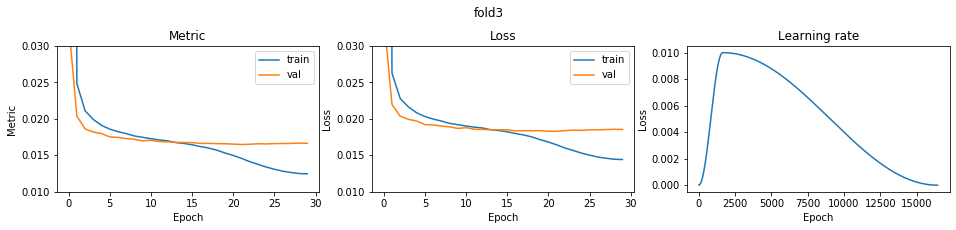

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.538626,0.5384195783,0.032658,0.0316282520,0:4
2,0.026330,0.0249045430,0.021291,0.0196558506,0:4
3,0.022837,0.0211500588,0.020074,0.0183665563,0:4
4,0.021800,0.0200657914,0.019593,0.0178854746,0:4
5,0.020864,0.0191291172,0.019309,0.0175930311,0:4
6,0.020386,0.0186557877,0.019061,0.0173490461,0:4
7,0.020063,0.0183321709,0.019037,0.0172980933,0:4
8,0.019696,0.0179670939,0.019013,0.0172982570,0:4
9,0.019468,0.0177381140,0.018699,0.0169924829,0:4
10,0.019243,0.0175058454,0.018745,0.0170349409,0:4


epoch1 save best model... 0.03162825195063627
epoch2 save best model... 0.019655850611983508
epoch3 save best model... 0.018366556295993524
epoch4 save best model... 0.017885474598030974
epoch5 save best model... 0.017593031149603647
epoch6 save best model... 0.01734904610511586
epoch7 save best model... 0.01729809332571092
epoch9 save best model... 0.01699248294649404
epoch12 save best model... 0.016797452289314098
epoch14 save best model... 0.01679258369596713
epoch15 save best model... 0.016663993633689533
epoch16 save best model... 0.016637745057922152
epoch18 save best model... 0.016600559013291074
epoch19 save best model... 0.01657334703247748
epoch20 save best model... 0.016476200025418355
fold4 score: 0.016476199964104668


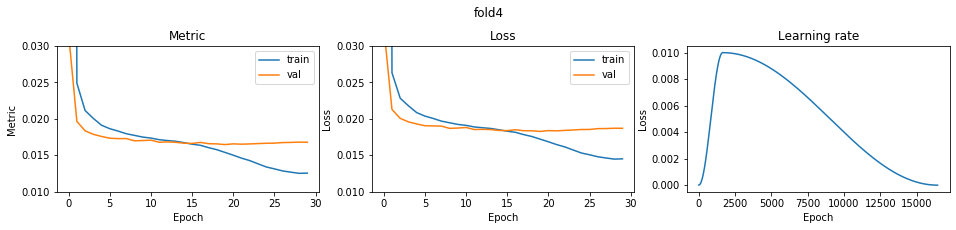

CV score: 0.016408089304482752

optimizer: RangerVA
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.764321,0.7643199398,0.699091,0.6990863259,0:5
2,0.652651,0.6525993970,0.387811,0.3876191915,0:5
3,0.130052,0.1293934313,0.034633,0.0336544449,0:5
4,0.031208,0.0300641919,0.024638,0.0234064318,0:5
5,0.026006,0.0246956620,0.023029,0.0216592698,0:5
6,0.024500,0.0230994473,0.022213,0.0208007949,0:5
7,0.023835,0.0223839325,0.021918,0.0204441812,0:5
8,0.023414,0.0219239460,0.021570,0.0200706198,0:5
9,0.023096,0.0215812110,0.021413,0.0198724826,0:5
10,0.022774,0.0212377711,0.021216,0.0196755298,0:5


epoch1 save best model... 0.6990863259398041
epoch2 save best model... 0.3876191914624668
epoch3 save best model... 0.033654444863285726
epoch4 save best model... 0.023406431777296684
epoch5 save best model... 0.021659269802492952
epoch6 save best model... 0.020800794928349502
epoch7 save best model... 0.020444181198275443
epoch8 save best model... 0.02007061984296676
epoch9 save best model... 0.019872482613170338
epoch10 save best model... 0.01967552979147923
epoch11 save best model... 0.019401854095908395
epoch12 save best model... 0.019257752809478373
epoch13 save best model... 0.01907290058350509
epoch14 save best model... 0.018940914539378434
epoch15 save best model... 0.018824396460637417
epoch16 save best model... 0.01873912575117955
epoch17 save best model... 0.01864915968667809
epoch18 save best model... 0.018631658559677813
epoch19 save best model... 0.018573065603614398
epoch20 save best model... 0.018507061241054588
epoch21 save best model... 0.01845490137764289
epoch22 sav

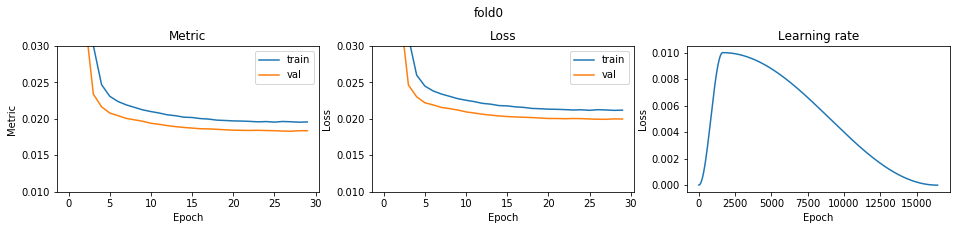

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.762451,0.7624492255,0.693869,0.6938621101,0:5
2,0.650983,0.6509302490,0.371510,0.3713043429,0:5
3,0.130983,0.1303253565,0.033241,0.0322316900,0:5
4,0.031322,0.0301792125,0.024311,0.0230549456,0:5
5,0.025862,0.0245487289,0.022771,0.0214085368,0:5
6,0.024510,0.0231087596,0.022296,0.0208462826,0:5
7,0.023711,0.0222581453,0.021767,0.0202965203,0:5
8,0.023229,0.0217401461,0.021555,0.0200560296,0:5
9,0.022883,0.0213657908,0.021302,0.0197705347,0:5
10,0.022495,0.0209605046,0.021055,0.0195133365,0:5


epoch1 save best model... 0.6938621101251194
epoch2 save best model... 0.37130434285890923
epoch3 save best model... 0.03223168996614051
epoch4 save best model... 0.023054945584591143
epoch5 save best model... 0.02140853684552576
epoch6 save best model... 0.020846282567181275
epoch7 save best model... 0.020296520322873615
epoch8 save best model... 0.020056029589450776
epoch9 save best model... 0.01977053468448137
epoch10 save best model... 0.019513336467556867
epoch11 save best model... 0.019404884185035127
epoch12 save best model... 0.01921152013595269
epoch13 save best model... 0.019117640275792505
epoch14 save best model... 0.019003303175782336
epoch15 save best model... 0.018841408356925736
epoch16 save best model... 0.0188001945099606
epoch17 save best model... 0.018733655768630172
epoch18 save best model... 0.018691006823814006
epoch20 save best model... 0.018594555408662235
epoch22 save best model... 0.018582624151766314
epoch23 save best model... 0.018521044598109333
epoch24 sa

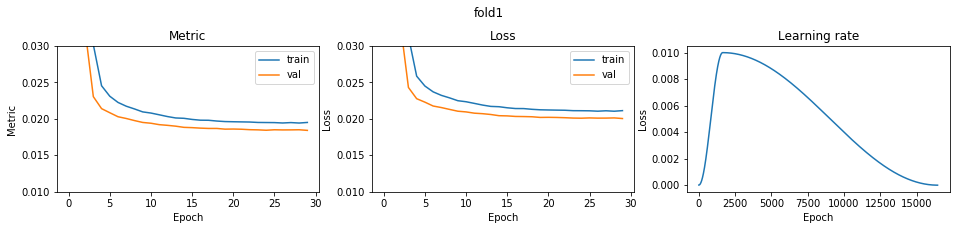

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.764271,0.7642698392,0.696728,0.6967205474,0:5
2,0.650238,0.6501844366,0.368762,0.3685556605,0:5
3,0.128052,0.1273879560,0.032889,0.0318779881,0:5
4,0.031196,0.0300500186,0.024329,0.0230623599,0:5
5,0.025895,0.0245832488,0.022776,0.0214026223,0:5
6,0.024465,0.0230660378,0.022220,0.0207683959,0:5
7,0.023772,0.0223161108,0.021789,0.0203161705,0:5
8,0.023295,0.0218052938,0.021570,0.0200443963,0:5
9,0.022935,0.0214209317,0.021329,0.0197782501,0:5
10,0.022544,0.0210056448,0.021130,0.0195499213,0:5


epoch1 save best model... 0.6967205473680815
epoch2 save best model... 0.3685556605006709
epoch3 save best model... 0.03187798811337092
epoch4 save best model... 0.02306235987946856
epoch5 save best model... 0.021402622323324506
epoch6 save best model... 0.020768395898573815
epoch7 save best model... 0.020316170488638468
epoch8 save best model... 0.02004439631503735
epoch9 save best model... 0.019778250139244842
epoch10 save best model... 0.019549921348921855
epoch11 save best model... 0.019315672351064798
epoch12 save best model... 0.019175006776087293
epoch13 save best model... 0.019003726569581315
epoch14 save best model... 0.01890880526437096
epoch15 save best model... 0.018779368766414384
epoch16 save best model... 0.018709936208715743
epoch17 save best model... 0.018632514924057104
epoch18 save best model... 0.018571834815388103
epoch19 save best model... 0.018522676327035567
epoch20 save best model... 0.018496201999186723
epoch21 save best model... 0.018415222036968226
epoch24 s

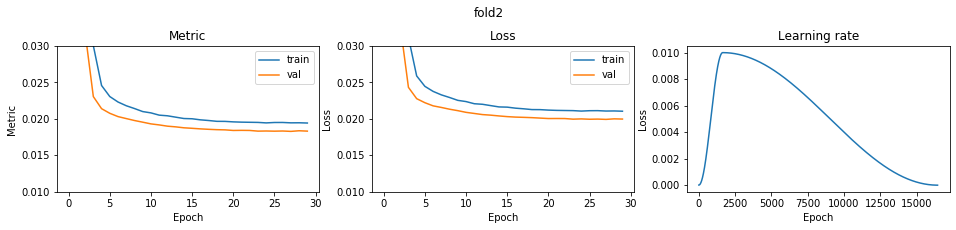

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.761564,0.7615607648,0.691516,0.6915081832,0:5
2,0.650001,0.6499475615,0.376556,0.3763548333,0:5
3,0.129635,0.1289760359,0.034114,0.0331291034,0:5
4,0.031293,0.0301512180,0.024619,0.0233580979,0:5
5,0.025844,0.0245361707,0.023071,0.0217146678,0:5
6,0.024335,0.0229382312,0.022439,0.0209981980,0:5
7,0.023780,0.0223282525,0.022097,0.0206232225,0:5
8,0.023287,0.0217977964,0.021821,0.0203267824,0:5
9,0.022992,0.0214750691,0.021646,0.0201272069,0:5
10,0.022605,0.0210647626,0.021337,0.0197880356,0:5


epoch1 save best model... 0.6915081832294855
epoch2 save best model... 0.3763548332765054
epoch3 save best model... 0.03312910342406575
epoch4 save best model... 0.023358097905823473
epoch5 save best model... 0.021714667817217072
epoch6 save best model... 0.020998197958586155
epoch7 save best model... 0.020623222537813943
epoch8 save best model... 0.02032678239005098
epoch9 save best model... 0.020127206852400766
epoch10 save best model... 0.0197880355573359
epoch11 save best model... 0.019659274075273635
epoch12 save best model... 0.01946690694889338
epoch13 save best model... 0.01933261855868177
epoch14 save best model... 0.01915757156280559
epoch15 save best model... 0.019093041555162577
epoch16 save best model... 0.0189596116962866
epoch17 save best model... 0.018897876401001202
epoch18 save best model... 0.01888855270074006
epoch19 save best model... 0.01881760151246414
epoch20 save best model... 0.01875822722300853
epoch21 save best model... 0.018741795774082522
epoch22 save best

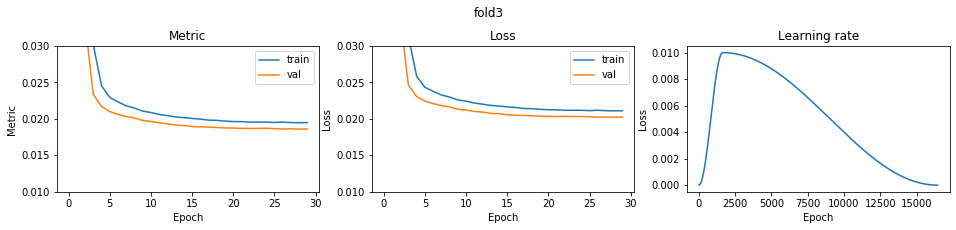

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.762934,0.7629323427,0.695796,0.6957899068,0:5
2,0.653175,0.6531242775,0.382956,0.3827599032,0:5
3,0.132241,0.1315875202,0.033711,0.0327216204,0:5
4,0.031476,0.0303375465,0.024330,0.0230847645,0:5
5,0.026069,0.0247605288,0.022691,0.0213362276,0:5
6,0.024617,0.0232164294,0.022098,0.0206570165,0:5
7,0.023915,0.0224612033,0.021734,0.0202521199,0:5
8,0.023463,0.0219723548,0.021472,0.0199602958,0:5
9,0.023096,0.0215800838,0.021220,0.0196982360,0:5
10,0.022727,0.0211877583,0.021093,0.0195230634,0:5


epoch1 save best model... 0.6957899067559383
epoch2 save best model... 0.38275990319143394
epoch3 save best model... 0.03272162035430075
epoch4 save best model... 0.023084764533033403
epoch5 save best model... 0.021336227637590473
epoch6 save best model... 0.020657016534638296
epoch7 save best model... 0.020252119939019035
epoch8 save best model... 0.01996029579422197
epoch9 save best model... 0.01969823600355205
epoch10 save best model... 0.019523063382655723
epoch11 save best model... 0.019242791945203834
epoch12 save best model... 0.019112899834141644
epoch13 save best model... 0.018981011105798914
epoch14 save best model... 0.01886116608909431
epoch15 save best model... 0.018717637927120803
epoch16 save best model... 0.01863621992137546
epoch17 save best model... 0.018587479694557624
epoch18 save best model... 0.01849066025168043
epoch20 save best model... 0.0184386062921621
epoch21 save best model... 0.01840696665617491
epoch22 save best model... 0.018359539304395336
epoch24 save 

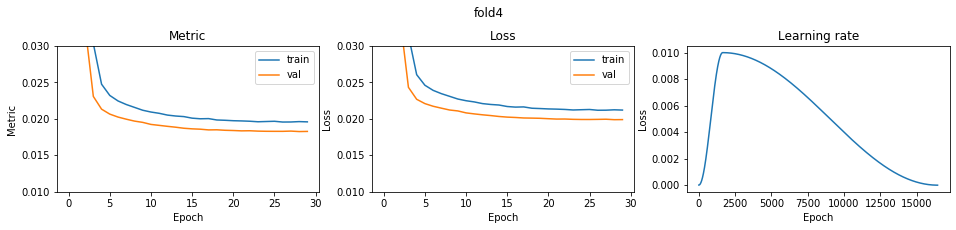

CV score: 0.018376362018102957

optimizer: SWATS
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.622485,0.6223856514,0.060782,0.0600277334,0:7
2,0.029193,0.0278841153,0.021815,0.0202758612,0:7
3,0.022580,0.0209788647,0.020288,0.0186413246,0:7
4,0.021421,0.0197575961,0.019663,0.0179747234,0:7
5,0.020646,0.0189596802,0.019225,0.0175275968,0:7
6,0.020217,0.0185225176,0.018955,0.0172415392,0:7
7,0.019808,0.0181053694,0.018749,0.0170185383,0:7
8,0.019429,0.0177152868,0.018623,0.0169029777,0:6
9,0.019079,0.0173535677,0.018455,0.0167094734,0:7
10,0.018756,0.0170221994,0.018364,0.0166358053,0:7


epoch1 save best model... 0.060027733411224124
epoch2 save best model... 0.020275861215788303
epoch3 save best model... 0.01864132463830207
epoch4 save best model... 0.017974723363825565
epoch5 save best model... 0.01752759679591873
epoch6 save best model... 0.017241539192600238
epoch7 save best model... 0.017018538255219037
epoch8 save best model... 0.0169029777177985
epoch9 save best model... 0.016709473435523026
epoch10 save best model... 0.01663580534042014
epoch11 save best model... 0.01652324361247191
epoch12 save best model... 0.016458189353380767
epoch13 save best model... 0.016318378992090193
epoch15 save best model... 0.016274596051501795
epoch16 save best model... 0.01625761764807147
epoch17 save best model... 0.016204084092348067
epoch18 save best model... 0.01614422919631751
epoch21 save best model... 0.01611748646248921
epoch23 save best model... 0.01611390800718091
epoch24 save best model... 0.016111228157233676
epoch26 save best model... 0.016080869151733325
fold0 score

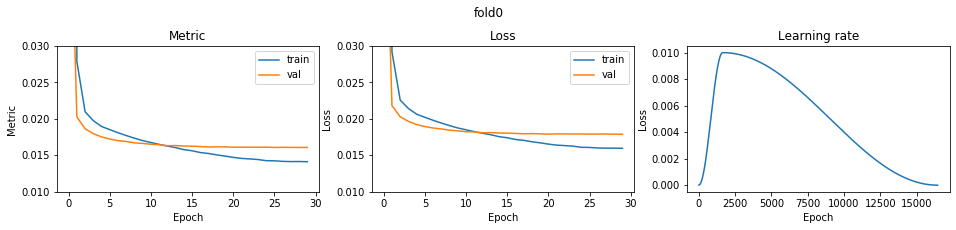

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.624591,0.6244915312,0.056565,0.0557929410,0:7
2,0.028930,0.0276215201,0.021869,0.0203023623,0:7
3,0.022458,0.0208525493,0.020458,0.0188055802,0:6
4,0.021293,0.0196326349,0.019968,0.0183076610,0:7
5,0.020797,0.0191110589,0.019539,0.0178379974,0:7
6,0.020118,0.0184242277,0.019336,0.0176197532,0:6
7,0.019707,0.0180014220,0.019047,0.0173276603,0:7
8,0.019319,0.0176030136,0.018869,0.0171490624,0:7
9,0.019071,0.0173514902,0.018684,0.0169669925,0:6
10,0.018715,0.0169782578,0.018605,0.0168781056,0:7


epoch1 save best model... 0.05579294102284679
epoch2 save best model... 0.020302362288913876
epoch3 save best model... 0.018805580242948833
epoch4 save best model... 0.018307660962460278
epoch5 save best model... 0.01783799739097457
epoch6 save best model... 0.017619753179625677
epoch7 save best model... 0.01732766032380201
epoch8 save best model... 0.017149062370586488
epoch9 save best model... 0.016966992498588306
epoch10 save best model... 0.016878105621716176
epoch12 save best model... 0.016747416467948015
epoch13 save best model... 0.016687597179313025
epoch14 save best model... 0.01664766041134601
epoch15 save best model... 0.016574683956297718
epoch16 save best model... 0.016535147415560208
epoch17 save best model... 0.01650716036946043
epoch18 save best model... 0.016449332085948825
epoch20 save best model... 0.016421786817985357
epoch22 save best model... 0.016394345677996938
epoch26 save best model... 0.016389438637597436
epoch28 save best model... 0.016382386687677036
fold1 

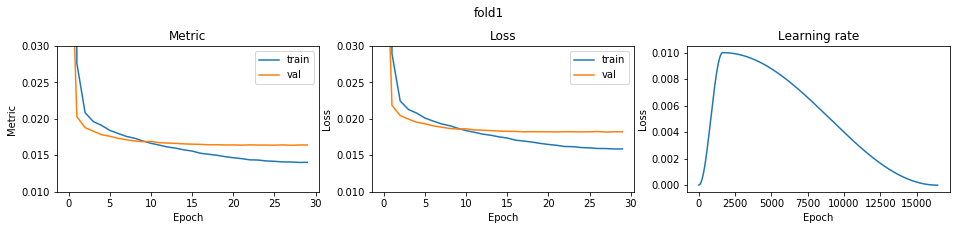

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.623342,0.6232423333,0.062013,0.0612698290,0:7
2,0.028890,0.0275846376,0.022193,0.0206575517,0:7
3,0.022601,0.0210009546,0.020357,0.0187218422,0:7
4,0.021456,0.0197959216,0.019759,0.0181167381,0:7
5,0.020683,0.0190035543,0.019269,0.0175755001,0:7
6,0.020227,0.0185287657,0.018945,0.0172721073,0:7
7,0.019681,0.0179764364,0.018715,0.0170128794,0:7
8,0.019351,0.0176378693,0.018703,0.0169812280,0:7
9,0.019045,0.0173168823,0.018447,0.0167362260,0:7
10,0.018783,0.0170488710,0.018369,0.0166387601,0:7


epoch1 save best model... 0.06126982897798465
epoch2 save best model... 0.02065755171189074
epoch3 save best model... 0.018721842157997583
epoch4 save best model... 0.018116738133711324
epoch5 save best model... 0.01757550012811723
epoch6 save best model... 0.01727210727258651
epoch7 save best model... 0.01701287936744331
epoch8 save best model... 0.016981228004557907
epoch9 save best model... 0.016736226038373693
epoch10 save best model... 0.016638760112258264
epoch12 save best model... 0.016530113761336812
epoch13 save best model... 0.016437701199999034
epoch14 save best model... 0.016391251060078726
epoch15 save best model... 0.016368347743394965
epoch16 save best model... 0.016327238495264938
epoch17 save best model... 0.01629576709810674
epoch19 save best model... 0.016247180064745022
epoch20 save best model... 0.016232647959378035
epoch21 save best model... 0.016214154816877057
epoch25 save best model... 0.016213976413963882
epoch26 save best model... 0.0162090348231732
epoch28 s

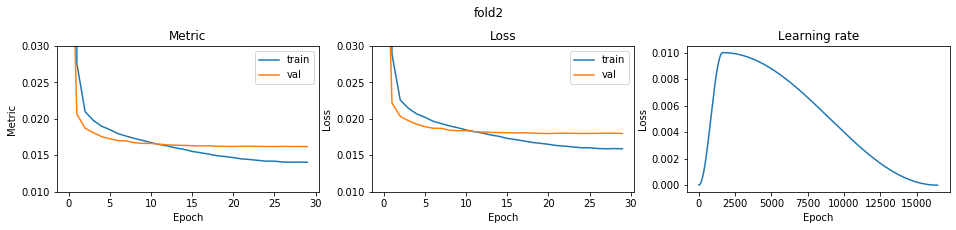

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.621762,0.6216605779,0.056362,0.0555733398,0:7
2,0.029124,0.0278114340,0.021849,0.0202878898,0:7
3,0.022440,0.0208364901,0.020672,0.0190094111,0:7
4,0.021451,0.0197890253,0.019870,0.0181651133,0:7
5,0.020678,0.0189986252,0.019502,0.0178088864,0:7
6,0.020109,0.0184151237,0.019209,0.0175206227,0:7
7,0.019704,0.0179989698,0.019021,0.0173171242,0:7
8,0.019342,0.0176265301,0.018900,0.0171819927,0:7
9,0.019056,0.0173324982,0.018795,0.0170716772,0:7
10,0.018798,0.0170690403,0.018692,0.0169540886,0:7


epoch1 save best model... 0.05557333976200067
epoch2 save best model... 0.020287889841273596
epoch3 save best model... 0.01900941108041581
epoch4 save best model... 0.018165113259285076
epoch5 save best model... 0.017808886445583542
epoch6 save best model... 0.017520622657887758
epoch7 save best model... 0.01731712423680787
epoch8 save best model... 0.01718199272769459
epoch9 save best model... 0.017071677163531813
epoch10 save best model... 0.016954088642141
epoch11 save best model... 0.016836022059507412
epoch12 save best model... 0.016703485990694145
epoch13 save best model... 0.016666517119880146
epoch14 save best model... 0.01662378352695486
epoch15 save best model... 0.016556732343819526
epoch16 save best model... 0.016475463598745965
epoch17 save best model... 0.016461847367397336
epoch19 save best model... 0.016420479789630835
epoch24 save best model... 0.016403928062197558
epoch28 save best model... 0.016399225223054238
fold3 score: 0.016399225129205122


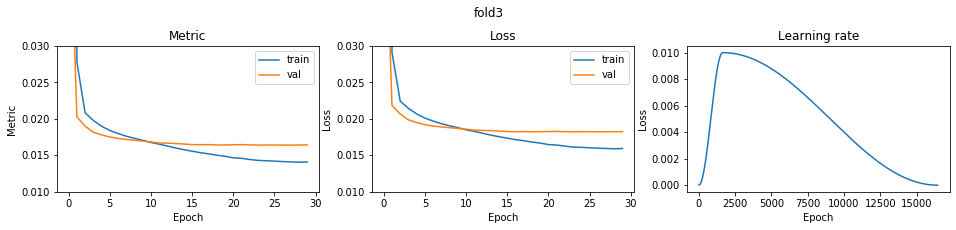

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.624740,0.6246411449,0.061058,0.0603129574,0:7
2,0.029058,0.0277508215,0.021371,0.0197978644,0:6
3,0.022479,0.0208683481,0.020274,0.0186114330,0:7
4,0.021315,0.0196512218,0.019530,0.0178422490,0:7
5,0.020630,0.0189487716,0.019312,0.0176064104,0:7
6,0.020128,0.0184307773,0.019189,0.0174666357,0:7
7,0.019649,0.0179451840,0.018831,0.0171245283,0:7
8,0.019392,0.0176754346,0.018676,0.0169831927,0:6
9,0.019037,0.0173104717,0.018606,0.0168932178,0:7
10,0.018793,0.0170600552,0.018596,0.0168583214,0:7


epoch1 save best model... 0.06031295735058046
epoch2 save best model... 0.019797864437510592
epoch3 save best model... 0.018611432985319906
epoch4 save best model... 0.017842249013483524
epoch5 save best model... 0.01760641036508499
epoch6 save best model... 0.01746663570208878
epoch7 save best model... 0.017124528256255565
epoch8 save best model... 0.016983192693654253
epoch9 save best model... 0.01689321782804839
epoch10 save best model... 0.016858321414721582
epoch11 save best model... 0.016671543800460858
epoch13 save best model... 0.01658744466679854
epoch14 save best model... 0.016567658765797327
epoch15 save best model... 0.016509241292121606
epoch16 save best model... 0.016491562056785834
epoch17 save best model... 0.01648624769978412
epoch18 save best model... 0.016391984029229655
epoch20 save best model... 0.016369599772188687
epoch22 save best model... 0.016361352694825457
fold4 score: 0.01636135264576075


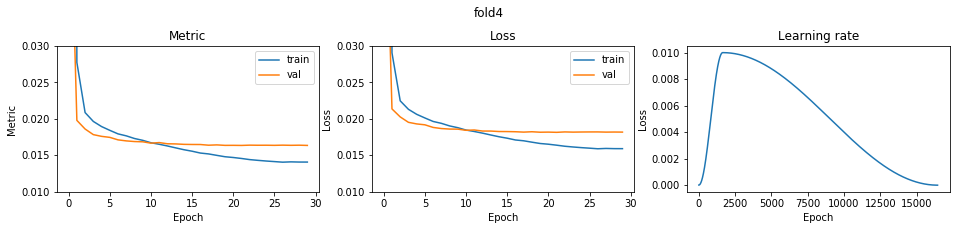

CV score: 0.01628463128713695

optimizer: Yogi
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.630056,0.6299666880,0.075132,0.0744398105,0:4
2,0.031018,0.0297548287,0.022086,0.0205600278,0:4
3,0.022879,0.0213021803,0.020698,0.0190714340,0:4
4,0.021722,0.0200805995,0.020024,0.0183890439,0:4
5,0.020883,0.0192178329,0.019364,0.0177024628,0:4
6,0.020331,0.0186551639,0.019074,0.0173926436,0:4
7,0.020008,0.0183206735,0.018960,0.0172752254,0:4
8,0.019575,0.0178774621,0.018706,0.0170057729,0:4
9,0.019354,0.0176488348,0.018601,0.0169113484,0:4
10,0.019077,0.0173645016,0.018466,0.0167469156,0:4


epoch1 save best model... 0.07443981048797421
epoch2 save best model... 0.0205600277853786
epoch3 save best model... 0.019071433969809416
epoch4 save best model... 0.018389043854316167
epoch5 save best model... 0.017702462832212176
epoch6 save best model... 0.01739264359370994
epoch7 save best model... 0.017275225426280415
epoch8 save best model... 0.01700577287762882
epoch9 save best model... 0.01691134840266987
epoch10 save best model... 0.016746915620592568
epoch11 save best model... 0.016693800653846496
epoch12 save best model... 0.01656168839875142
epoch13 save best model... 0.016549555275903204
epoch14 save best model... 0.016467022876295524
epoch15 save best model... 0.016376954638706795
epoch16 save best model... 0.016348197384989886
epoch17 save best model... 0.016319982510628623
epoch18 save best model... 0.016313142259870413
epoch19 save best model... 0.01625947428523544
epoch20 save best model... 0.016211107006648677
epoch21 save best model... 0.016186123037528338
epoch23 s

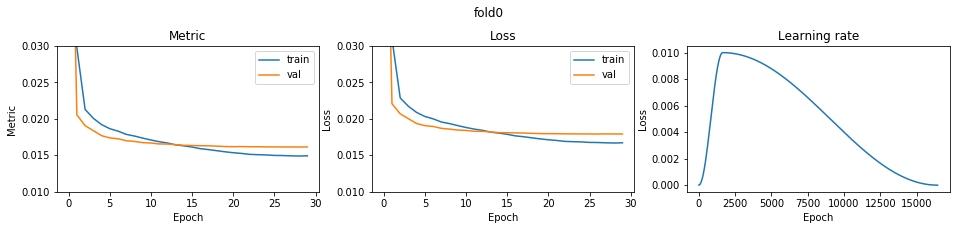

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.632420,0.6323326004,0.076675,0.0760030914,0:4
2,0.031229,0.0299697879,0.021977,0.0204590701,0:4
3,0.022567,0.0209944402,0.020658,0.0190411392,0:4
4,0.021565,0.0199238351,0.020117,0.0184349501,0:4
5,0.020723,0.0190551343,0.019624,0.0179543812,0:4
6,0.020349,0.0186676742,0.019350,0.0176848478,0:4
7,0.019867,0.0181772928,0.019160,0.0174450053,0:4
8,0.019578,0.0178771790,0.019056,0.0173583000,0:4
9,0.019249,0.0175451924,0.018906,0.0171914250,0:4
10,0.019050,0.0173341211,0.018913,0.0171916348,0:4


epoch1 save best model... 0.07600309140428538
epoch2 save best model... 0.02045907009258021
epoch3 save best model... 0.01904113922759595
epoch4 save best model... 0.018434950087527584
epoch5 save best model... 0.017954381205282442
epoch6 save best model... 0.01768484778276172
epoch7 save best model... 0.017445005314358004
epoch8 save best model... 0.01735829996226466
epoch9 save best model... 0.017191424981136478
epoch11 save best model... 0.01695088222924188
epoch12 save best model... 0.016847775279109082
epoch13 save best model... 0.01682406179390476
epoch14 save best model... 0.01673146921103257
epoch15 save best model... 0.01671447998558261
epoch16 save best model... 0.016665594138783917
epoch17 save best model... 0.016623957520811278
epoch18 save best model... 0.016609118439089087
epoch19 save best model... 0.016569390599092813
epoch21 save best model... 0.016533515192644694
epoch22 save best model... 0.016532637727421178
epoch23 save best model... 0.016523879374922557
epoch24 sa

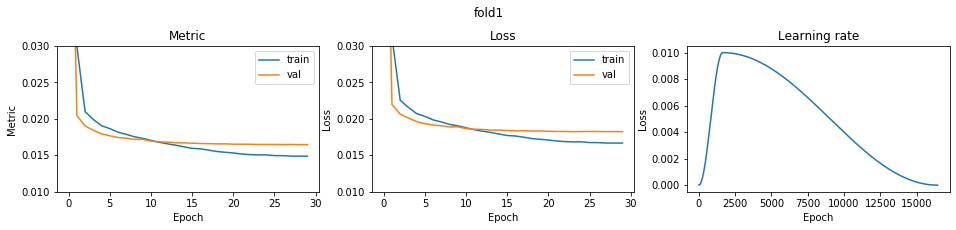

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.635137,0.6350518934,0.080566,0.0799033703,0:4
2,0.031296,0.0300397747,0.022069,0.0205483280,0:4
3,0.022638,0.0210604591,0.020619,0.0189648048,0:4
4,0.021551,0.0199027577,0.019929,0.0182630274,0:4
5,0.020742,0.0190739021,0.019464,0.0177622941,0:4
6,0.020367,0.0186874748,0.019095,0.0174086583,0:4
7,0.019873,0.0181813934,0.019007,0.0173266835,0:4
8,0.019581,0.0178827634,0.018832,0.0171279583,0:4
9,0.019321,0.0176155771,0.018644,0.0169363355,0:4
10,0.019043,0.0173305004,0.018600,0.0168892792,0:4


epoch1 save best model... 0.0799033702791457
epoch2 save best model... 0.020548327962404696
epoch3 save best model... 0.018964804822694036
epoch4 save best model... 0.018263027352049835
epoch5 save best model... 0.017762294100666678
epoch6 save best model... 0.01740865833593898
epoch7 save best model... 0.01732668345257229
epoch8 save best model... 0.017127958286360948
epoch9 save best model... 0.016936335493261952
epoch10 save best model... 0.0168892792333745
epoch11 save best model... 0.016764781559613997
epoch12 save best model... 0.016640532183369434
epoch13 save best model... 0.01654337707475782
epoch14 save best model... 0.016510703899076655
epoch15 save best model... 0.016387708403855922
epoch16 save best model... 0.016367878771658014
epoch17 save best model... 0.016339543963258155
epoch18 save best model... 0.0163095641155946
epoch19 save best model... 0.01630781682924974
epoch21 save best model... 0.016303935838749943
epoch22 save best model... 0.016256135991948712
epoch23 sav

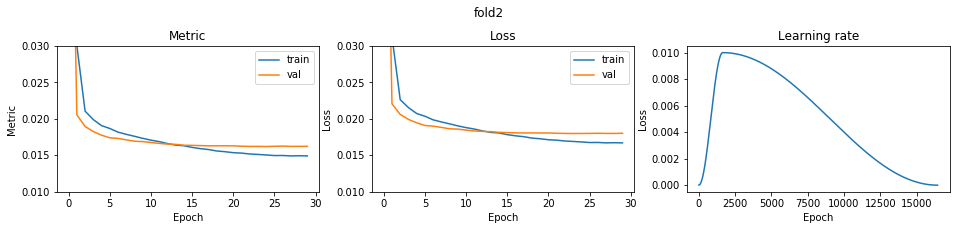

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.631238,0.6311501310,0.078353,0.0776832849,0:4
2,0.031028,0.0297670246,0.022049,0.0205506951,0:4
3,0.022650,0.0210746186,0.020582,0.0189603205,0:4
4,0.021510,0.0198671122,0.019969,0.0182925129,0:4
5,0.020794,0.0191264349,0.019653,0.0179899670,0:4
6,0.020174,0.0184955618,0.019390,0.0176988808,0:4
7,0.019896,0.0182050743,0.019114,0.0174377092,0:4
8,0.019490,0.0177930762,0.019066,0.0173733178,0:4
9,0.019317,0.0176096448,0.018891,0.0171996183,0:4
10,0.019005,0.0172913850,0.018784,0.0170700680,0:4


epoch1 save best model... 0.07768328489570249
epoch2 save best model... 0.02055069513338913
epoch3 save best model... 0.018960320467982177
epoch4 save best model... 0.018292512887227507
epoch5 save best model... 0.017989966964480682
epoch6 save best model... 0.017698880785690083
epoch7 save best model... 0.017437709243819627
epoch8 save best model... 0.01737331783522031
epoch9 save best model... 0.017199618298059716
epoch10 save best model... 0.017070068012931486
epoch11 save best model... 0.017001613632166984
epoch12 save best model... 0.016872873890864958
epoch13 save best model... 0.016795691661536695
epoch15 save best model... 0.01669136598612901
epoch16 save best model... 0.016650186672569137
epoch17 save best model... 0.01657467790686256
epoch18 save best model... 0.016570879509227015
epoch19 save best model... 0.0165236887188972
epoch20 save best model... 0.016463943937865502
epoch24 save best model... 0.016436412781561834
epoch25 save best model... 0.016431525095889944
epoch26 

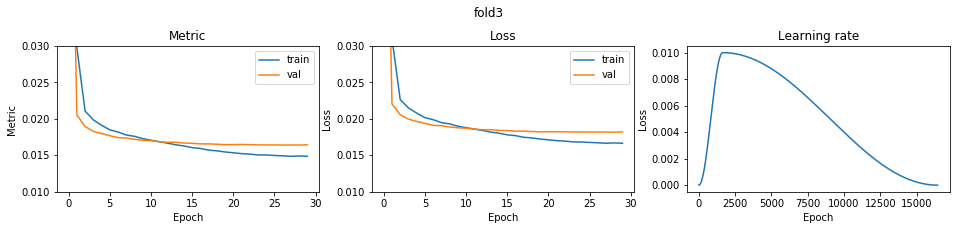

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.636711,0.6366276037,0.080494,0.0798379643,0:4
2,0.031370,0.0301135106,0.021642,0.0201146405,0:4
3,0.022613,0.0210377014,0.020443,0.0188212474,0:4
4,0.021495,0.0198592200,0.019703,0.0180387297,0:4
5,0.020841,0.0191755949,0.019380,0.0176993479,0:4
6,0.020303,0.0186261771,0.019158,0.0174786896,0:4
7,0.019913,0.0182209495,0.018943,0.0172457149,0:4
8,0.019620,0.0179218964,0.018921,0.0172232129,0:4
9,0.019354,0.0176492131,0.018735,0.0170450566,0:4
10,0.019091,0.0173788103,0.018670,0.0169453935,0:4


epoch1 save best model... 0.07983796433259252
epoch2 save best model... 0.020114640502051234
epoch3 save best model... 0.018821247377706553
epoch4 save best model... 0.018038729738639264
epoch5 save best model... 0.017699347878116816
epoch6 save best model... 0.017478689645122152
epoch7 save best model... 0.017245714932018232
epoch8 save best model... 0.017223212850579234
epoch9 save best model... 0.017045056560672903
epoch10 save best model... 0.016945393479817415
epoch11 save best model... 0.016928713340609247
epoch12 save best model... 0.016874026650974445
epoch13 save best model... 0.016775603459592153
epoch14 save best model... 0.01671101711902572
epoch15 save best model... 0.0166761083613258
epoch16 save best model... 0.016605302165336653
epoch18 save best model... 0.01656450660334972
epoch19 save best model... 0.016539803369645376
epoch20 save best model... 0.016464998644770277
epoch25 save best model... 0.016433435680179225
epoch26 save best model... 0.016425995664471647
fold4 

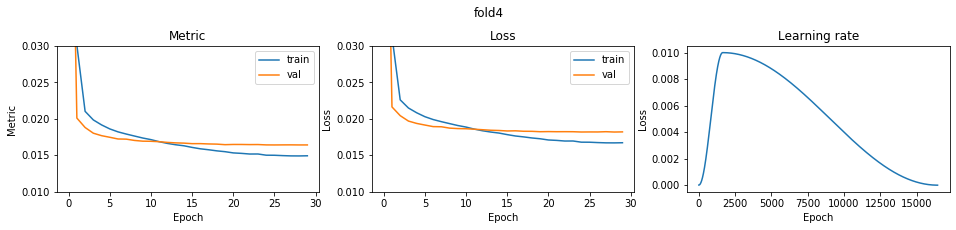

CV score: 0.016331912827999735

optimizer: Adam
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.438502,0.4380848051,0.023375,0.0219743356,0:4
2,0.024161,0.0225639815,0.021349,0.0196484741,0:4
3,0.022777,0.0210614639,0.020445,0.0187208698,0:4
4,0.021562,0.0198477535,0.019384,0.0176972980,0:4
5,0.020688,0.0189952014,0.019134,0.0174734575,0:4
6,0.020257,0.0185747126,0.019119,0.0174360339,0:4
7,0.019979,0.0182918797,0.019104,0.0174188481,0:4
8,0.019983,0.0182932781,0.018832,0.0171513175,0:4
9,0.019773,0.0180790641,0.018784,0.0171196819,0:4
10,0.019827,0.0181275379,0.018799,0.0171268360,0:4


epoch1 save best model... 0.021974335599834936
epoch2 save best model... 0.019648474107808296
epoch3 save best model... 0.01872086979465767
epoch4 save best model... 0.017697298026098478
epoch5 save best model... 0.0174734575194487
epoch6 save best model... 0.017436033909066933
epoch7 save best model... 0.017418848136800568
epoch8 save best model... 0.017151317545180983
epoch9 save best model... 0.017119681945490673
epoch12 save best model... 0.0169958652550851
epoch16 save best model... 0.01692996159246815
epoch17 save best model... 0.016775827227767073
epoch19 save best model... 0.0166164633540059
epoch20 save best model... 0.01655289457436303
epoch21 save best model... 0.016478243581356654
epoch22 save best model... 0.01643830543566402
epoch23 save best model... 0.016364601798406493
epoch24 save best model... 0.01632666556431927
epoch25 save best model... 0.016177838252420307
fold0 score: 0.016177838214154867


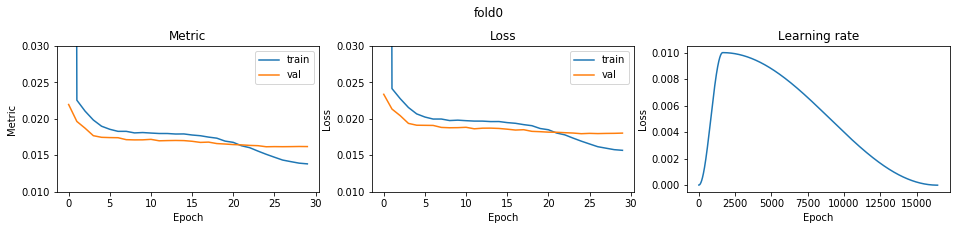

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.441052,0.4406373410,0.025517,0.0241350455,0:4
2,0.023920,0.0223299071,0.021849,0.0201514982,0:4
3,0.022695,0.0209751617,0.020162,0.0184715840,0:4
4,0.021325,0.0196117886,0.019590,0.0179088625,0:4
5,0.020539,0.0188471100,0.019444,0.0177950781,0:4
6,0.020107,0.0184185579,0.019232,0.0175710542,0:4
7,0.019938,0.0182498258,0.019062,0.0174056422,0:4
8,0.019733,0.0180348725,0.019029,0.0173474440,0:4
9,0.019590,0.0178855947,0.018954,0.0172875881,0:4
10,0.019599,0.0178916759,0.019114,0.0174342123,0:4


epoch1 save best model... 0.024135045475509178
epoch2 save best model... 0.020151498229903846
epoch3 save best model... 0.01847158403891886
epoch4 save best model... 0.017908862472602434
epoch5 save best model... 0.017795078136412203
epoch6 save best model... 0.017571054179179802
epoch7 save best model... 0.017405642196111674
epoch8 save best model... 0.017347443957916424
epoch9 save best model... 0.01728758809285518
epoch13 save best model... 0.01728733467508093
epoch16 save best model... 0.01727995896186976
epoch17 save best model... 0.017202078652949898
epoch18 save best model... 0.017007521987911996
epoch19 save best model... 0.016910577611562724
epoch20 save best model... 0.01680589543825695
epoch21 save best model... 0.01674102567472404
epoch22 save best model... 0.01661345730057187
epoch23 save best model... 0.016555321190228667
epoch24 save best model... 0.016507388083453086
epoch26 save best model... 0.016499473191127198
epoch27 save best model... 0.0164945418665287
epoch28 sa

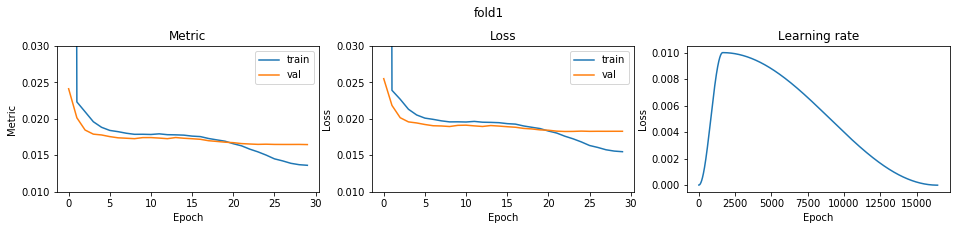

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.442733,0.4423222700,0.024710,0.0233257034,0:4
2,0.023955,0.0223755798,0.021205,0.0195071099,0:4
3,0.022953,0.0212105611,0.020499,0.0188068880,0:4
4,0.021511,0.0198035107,0.019554,0.0178936870,0:4
5,0.020611,0.0189257951,0.019351,0.0176935648,0:4
6,0.020209,0.0185273223,0.019176,0.0175002778,0:4
7,0.019986,0.0183006439,0.019171,0.0175271726,0:4
8,0.019838,0.0181437699,0.019047,0.0174144390,0:4
9,0.019832,0.0181381755,0.018871,0.0172304514,0:4
10,0.019741,0.0180389779,0.018895,0.0172349123,0:4


epoch1 save best model... 0.02332570344145164
epoch2 save best model... 0.019507109910490764
epoch3 save best model... 0.018806887994267642
epoch4 save best model... 0.01789368699733605
epoch5 save best model... 0.01769356484026036
epoch6 save best model... 0.017500277750803497
epoch8 save best model... 0.017414439032666977
epoch9 save best model... 0.017230451422558676
epoch14 save best model... 0.01707906503078402
epoch15 save best model... 0.01702066846310712
epoch17 save best model... 0.016988563899219877
epoch18 save best model... 0.01693280558845575
epoch19 save best model... 0.01682612723332449
epoch20 save best model... 0.0166907046464696
epoch21 save best model... 0.016684276108050924
epoch22 save best model... 0.016504485291885296
epoch23 save best model... 0.01640573058720431
epoch24 save best model... 0.016285537070482053
epoch25 save best model... 0.016215827596567166
epoch28 save best model... 0.016208307629998194
fold2 score: 0.0162083075152571


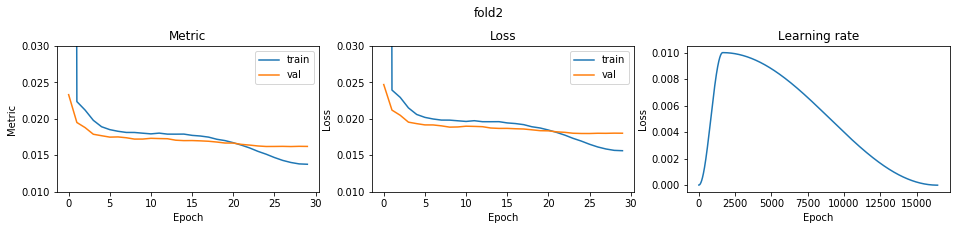

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.440114,0.4397015036,0.023531,0.0221469077,0:4
2,0.024034,0.0224514576,0.021535,0.0198272573,0:4
3,0.022933,0.0212065392,0.020516,0.0187976855,0:4
4,0.021482,0.0197719512,0.019820,0.0181303570,0:4
5,0.020552,0.0188632420,0.019541,0.0178570205,0:4
6,0.020155,0.0184711785,0.019203,0.0175390791,0:4
7,0.019974,0.0182899158,0.019225,0.0175292062,0:4
8,0.019835,0.0181433036,0.019076,0.0173918696,0:4
9,0.019683,0.0179841649,0.019060,0.0174231731,0:4
10,0.019701,0.0180009921,0.018977,0.0173004824,0:4


epoch1 save best model... 0.02214690770758719
epoch2 save best model... 0.019827257305095162
epoch3 save best model... 0.018797685531368968
epoch4 save best model... 0.01813035704331273
epoch5 save best model... 0.017857020477719757
epoch6 save best model... 0.017539079110976095
epoch7 save best model... 0.017529206220187873
epoch8 save best model... 0.017391869593369254
epoch10 save best model... 0.017300482430327727
epoch16 save best model... 0.01714436589678694
epoch17 save best model... 0.017081704922444728
epoch18 save best model... 0.016990987181765345
epoch19 save best model... 0.01687091355528131
epoch20 save best model... 0.016869166999172784
epoch21 save best model... 0.016758528295352817
epoch22 save best model... 0.016652576902834594
epoch23 save best model... 0.016591193770951588
epoch24 save best model... 0.01650372452584174
epoch25 save best model... 0.01649493173248472
epoch26 save best model... 0.016476088799621088
epoch27 save best model... 0.016439129954420352
epoch2

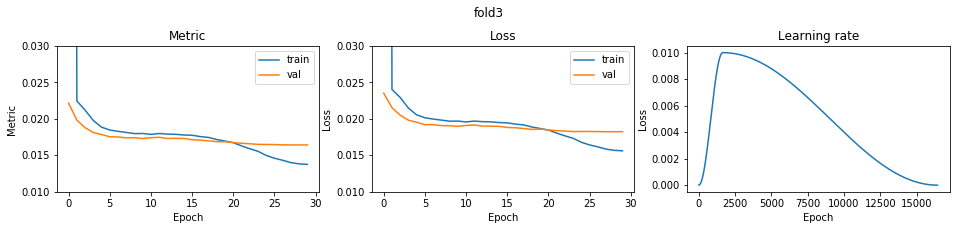

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.439896,0.4394816590,0.023289,0.0219127403,0:4
2,0.024303,0.0227187514,0.020800,0.0191027231,0:4
3,0.022880,0.0211395384,0.020160,0.0184457738,0:4
4,0.021703,0.0199895803,0.019712,0.0180156446,0:4
5,0.020681,0.0189872911,0.019448,0.0177718830,0:4
6,0.020303,0.0186234649,0.019180,0.0175132737,0:4
7,0.020065,0.0183835513,0.019164,0.0174809987,0:4
8,0.019903,0.0182142462,0.019033,0.0173766638,0:4
9,0.019774,0.0180790214,0.019025,0.0173200165,0:4
10,0.019764,0.0180678003,0.019190,0.0174400651,0:4


epoch1 save best model... 0.021912740275331674
epoch2 save best model... 0.019102723081012792
epoch3 save best model... 0.018445773802884348
epoch4 save best model... 0.018015644612779377
epoch5 save best model... 0.017771882975817676
epoch6 save best model... 0.01751327374631832
epoch7 save best model... 0.017480998686122323
epoch8 save best model... 0.017376663805683545
epoch9 save best model... 0.01732001647964154
epoch13 save best model... 0.017079117770703478
epoch16 save best model... 0.016984027182865794
epoch19 save best model... 0.016830588694330906
epoch20 save best model... 0.01673011738925765
epoch21 save best model... 0.01659092353762961
epoch22 save best model... 0.016582326994941554
epoch23 save best model... 0.01647618105401686
epoch24 save best model... 0.016454237400382283
epoch25 save best model... 0.016427394715063527
epoch26 save best model... 0.0163981483150316
epoch29 save best model... 0.016387221389842603
fold4 score: 0.016387221294951296


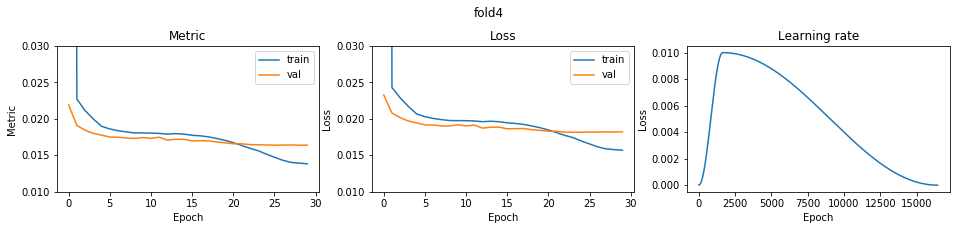

CV score: 0.016334986667240543


In [21]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [22]:
score_dict

{'AdaBelief': 0.33984046572666754,
 'AdaBound': 0.02001566279321151,
 'AdaMod': 0.016410009667571113,
 'AdamP': 0.016382841716291393,
 'DiffGrad': 0.016409636840546676,
 'Lamb': 0.01646380807642481,
 'NovoGrad': 0.016271594316585404,
 'QHAdam': 0.01630947105537483,
 'RAdam': 0.016433031343862658,
 'Ranger': 0.01642123018251178,
 'RangerQH': 0.01640808930448273,
 'RangerVA': 0.01837636201810306,
 'SWATS': 0.01628463128713696,
 'Yogi': 0.0163319128279997,
 'Adam': 0.016334986667240616}

In [24]:
from collections import defaultdict
from torch.optim.optimizer import Optimizer
class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [25]:
optimizer = LookaheadYogi


optimizer: LookaheadYogi
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.720234,0.7202145291,0.472640,0.4725105146,0:4
2,0.093938,0.0930201798,0.023309,0.0219565065,0:4
3,0.023834,0.0223679783,0.021402,0.0198687202,0:4
4,0.022408,0.0208358755,0.020679,0.0190781397,0:4
5,0.021639,0.0200214159,0.020018,0.0183913678,0:4
6,0.021035,0.0193940545,0.019611,0.0179522240,0:4
7,0.020582,0.0189266377,0.019336,0.0176770040,0:4
8,0.020323,0.0186552496,0.019238,0.0175780626,0:4
9,0.020102,0.0184232377,0.019054,0.0173692516,0:4
10,0.019851,0.0181666543,0.018953,0.0172373707,0:4


epoch1 save best model... 0.47251051459334165
epoch2 save best model... 0.021956506467388268
epoch3 save best model... 0.019868720169253392
epoch4 save best model... 0.01907813974946805
epoch5 save best model... 0.018391367788840263
epoch6 save best model... 0.017952223952885097
epoch7 save best model... 0.01767700397598309
epoch8 save best model... 0.017578062594174524
epoch9 save best model... 0.017369251612548403
epoch10 save best model... 0.017237370703072373
epoch11 save best model... 0.01716332194270197
epoch12 save best model... 0.017040013796002826
epoch13 save best model... 0.016986759263249898
epoch14 save best model... 0.016926762638168075
epoch15 save best model... 0.016847066512513813
epoch16 save best model... 0.016793047119110213
epoch17 save best model... 0.01672995025398112
epoch18 save best model... 0.016669161302930672
epoch19 save best model... 0.01665983248272898
epoch20 save best model... 0.016624843898592073
epoch21 save best model... 0.01660973552639908
epoch22 

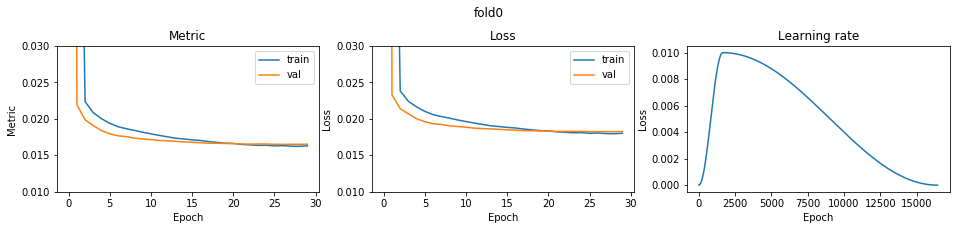

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.719683,0.7196633007,0.447800,0.4476524493,0:4
2,0.092320,0.0913961151,0.023088,0.0217120258,0:4
3,0.023736,0.0222654046,0.021481,0.0199171835,0:4
4,0.022239,0.0206588573,0.020667,0.0190483954,0:4
5,0.021460,0.0198379130,0.020241,0.0185658522,0:4
6,0.020958,0.0193156683,0.019787,0.0181016848,0:4
7,0.020615,0.0189584602,0.019654,0.0179496048,0:4
8,0.020325,0.0186565237,0.019449,0.0177561620,0:4
9,0.020103,0.0184244831,0.019304,0.0176098227,0:4
10,0.019825,0.0181431413,0.019181,0.0174691911,0:4


epoch1 save best model... 0.44765244929196757
epoch2 save best model... 0.021712025827805664
epoch3 save best model... 0.019917183547811426
epoch4 save best model... 0.019048395387762145
epoch5 save best model... 0.01856585221794152
epoch6 save best model... 0.018101684775014188
epoch7 save best model... 0.017949604761813707
epoch8 save best model... 0.017756161961333575
epoch9 save best model... 0.01760982274949741
epoch10 save best model... 0.01746919109914889
epoch11 save best model... 0.017458935448376595
epoch12 save best model... 0.017295510413693416
epoch13 save best model... 0.017168238270993005
epoch15 save best model... 0.017081100971531992
epoch16 save best model... 0.01705771684179778
epoch17 save best model... 0.017004580650114474
epoch18 save best model... 0.016987647126624213
epoch19 save best model... 0.016901633810437834
epoch20 save best model... 0.01684181792328402
epoch23 save best model... 0.01682392347202564
epoch25 save best model... 0.016781073437499062
fold1 sc

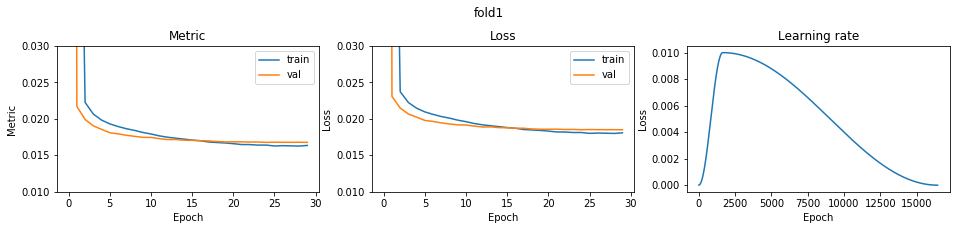

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.717615,0.7175947555,0.476123,0.4759958633,0:4
2,0.095730,0.0948123745,0.023292,0.0219361083,0:4
3,0.023692,0.0222251508,0.021469,0.0199028495,0:4
4,0.022266,0.0206894727,0.020494,0.0188734082,0:4
5,0.021487,0.0198642054,0.020108,0.0184727002,0:4
6,0.020995,0.0193472819,0.019628,0.0179772030,0:4
7,0.020527,0.0188742687,0.019419,0.0177398440,0:4
8,0.020237,0.0185701412,0.019388,0.0177350887,0:4
9,0.020055,0.0183817061,0.019191,0.0174995018,0:4
10,0.019735,0.0180526425,0.018986,0.0172867187,0:4


epoch1 save best model... 0.4759958632974479
epoch2 save best model... 0.021936108274811843
epoch3 save best model... 0.019902849485038843
epoch4 save best model... 0.018873408226702446
epoch5 save best model... 0.018472700243772067
epoch6 save best model... 0.017977203042381144
epoch7 save best model... 0.017739844019572498
epoch8 save best model... 0.01773508867610897
epoch9 save best model... 0.01749950183284299
epoch10 save best model... 0.017286718740471947
epoch11 save best model... 0.01716886135274415
epoch12 save best model... 0.01712576567440865
epoch13 save best model... 0.016996482586223733
epoch14 save best model... 0.016911752988607892
epoch15 save best model... 0.01680733700465147
epoch16 save best model... 0.016781984060904274
epoch17 save best model... 0.016768440183215598
epoch18 save best model... 0.01669128470510706
epoch19 save best model... 0.01665946839733347
epoch20 save best model... 0.016652763592863128
epoch21 save best model... 0.016617454661408217
epoch22 sa

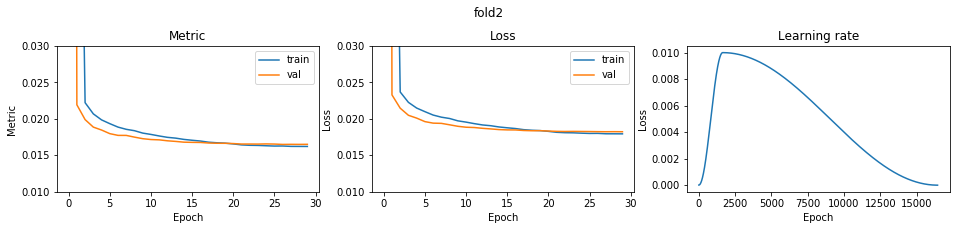

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.720750,0.7207310449,0.466590,0.4664557660,0:4
2,0.096498,0.0955845516,0.023267,0.0219355040,0:4
3,0.023740,0.0222732747,0.021644,0.0200954338,0:4
4,0.022276,0.0206966729,0.020795,0.0192030523,0:4
5,0.021611,0.0199910643,0.020222,0.0185994047,0:4
6,0.021138,0.0194983289,0.019888,0.0182379313,0:4
7,0.020707,0.0190537045,0.019824,0.0181691648,0:4
8,0.020392,0.0187222364,0.019548,0.0178731810,0:4
9,0.020053,0.0183790268,0.019384,0.0177050283,0:4
10,0.019850,0.0181702555,0.019232,0.0175480331,0:4


epoch1 save best model... 0.46645576604949585
epoch2 save best model... 0.021935504046109652
epoch3 save best model... 0.020095433820896104
epoch4 save best model... 0.019203052323116393
epoch5 save best model... 0.018599404704784613
epoch6 save best model... 0.01823793129957279
epoch7 save best model... 0.018169164810762455
epoch8 save best model... 0.017873180984754905
epoch9 save best model... 0.017705028278833777
epoch10 save best model... 0.017548033086358144
epoch11 save best model... 0.017474138168172577
epoch12 save best model... 0.017388561483396212
epoch13 save best model... 0.017280441786932648
epoch14 save best model... 0.017232266460505054
epoch15 save best model... 0.01712959540842402
epoch16 save best model... 0.017066883195641373
epoch17 save best model... 0.017011883657994196
epoch19 save best model... 0.016999898810610006
epoch20 save best model... 0.01689780399517277
epoch21 save best model... 0.016896027641833372
epoch24 save best model... 0.01681669882683249
epoch3

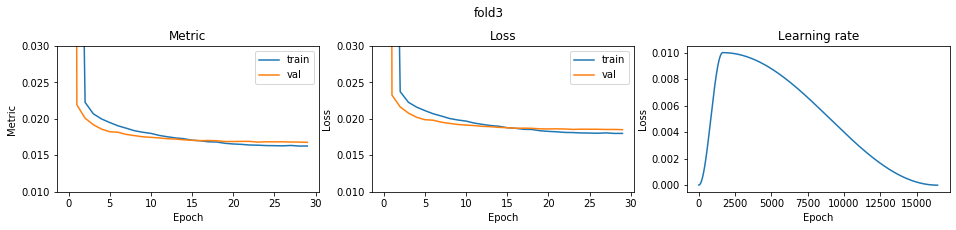

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.718640,0.7186200564,0.450077,0.4499313926,0:4
2,0.092888,0.0919631716,0.023083,0.0217104693,0:4
3,0.023772,0.0223030062,0.021115,0.0195631553,0:4
4,0.022230,0.0206527802,0.020354,0.0187336489,0:4
5,0.021560,0.0199407714,0.019950,0.0183029666,0:4
6,0.021069,0.0194278407,0.019611,0.0179388628,0:4
7,0.020573,0.0189193080,0.019434,0.0177443836,0:4
8,0.020289,0.0186293553,0.019264,0.0175745925,0:4
9,0.020009,0.0183356913,0.019150,0.0174572997,0:4
10,0.019812,0.0181320418,0.019037,0.0173462724,0:4


epoch1 save best model... 0.44993139263709203
epoch2 save best model... 0.02171046926739683
epoch3 save best model... 0.01956315532004236
epoch4 save best model... 0.018733648863326173
epoch5 save best model... 0.01830296662035727
epoch6 save best model... 0.017938862755843745
epoch7 save best model... 0.017744383597767706
epoch8 save best model... 0.017574592470986968
epoch9 save best model... 0.0174572996706076
epoch10 save best model... 0.01734627244489136
epoch11 save best model... 0.01727391844084974
epoch12 save best model... 0.017181498374459005
epoch13 save best model... 0.017042735360291255
epoch14 save best model... 0.017028802205598437
epoch15 save best model... 0.01693052505577887
epoch16 save best model... 0.016906888159692015
epoch17 save best model... 0.016862048204894897
epoch18 save best model... 0.016797322120118658
epoch20 save best model... 0.016769268714604317
epoch21 save best model... 0.016752014257828438
epoch22 save best model... 0.016716267519836275
epoch23 sa

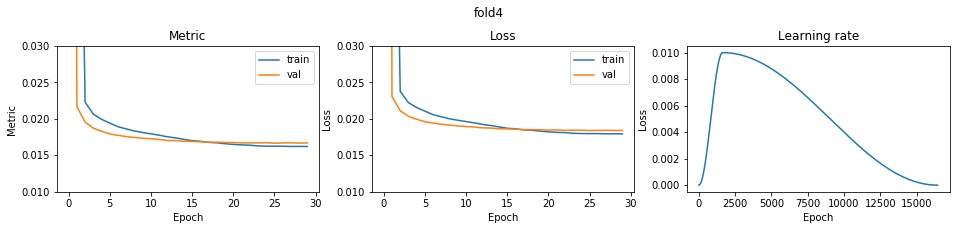

CV score: 0.01664794129096735


In [27]:
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score

In [41]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

,metric
AdaBelief,0.339840
AdaBound,0.020016
AdaMod,0.016410
AdamP,0.016383
DiffGrad,0.016410
Lamb,0.016464
NovoGrad,0.016272
QHAdam,0.016309
RAdam,0.016433
Ranger,0.016421


In [42]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                 metric
AdaBelief      0.339840
AdaBound       0.020016
AdaMod         0.016410
AdamP          0.016383
DiffGrad       0.016410
Lamb           0.016464
NovoGrad       0.016272
QHAdam         0.016309
RAdam          0.016433
Ranger         0.016421
RangerQH       0.016408
RangerVA       0.018376
SWATS          0.016285
Yogi           0.016332
Adam           0.016335
LookaheadYogi  0.016648
